# Load modules and files

## Import modules and show versions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import networkx as nx
from scipy.stats import norm
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.stats import beta

In [ ]:
!python --version
!pip freeze

Python 3.11.11
absl-py==1.4.0
accelerate==1.2.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2025.1.6.0.33.42
astunparse==1.6.3
atpublic==4.1.0
attrs==24.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.31.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.0.0
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.12.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.88
clarabel==0.9.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.31.2
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.3.1
c

In [ ]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['svg.fonttype'] = 'none'

## functions for common use

In [ ]:
# Calculate confedence interval of ratio from binary data (prior: beta(1, 1))
## a: count of success
## b: count of fail
## p: percentage of interval
def binom_confedence(a, b, p):#p represents the width of credible interval (e.g. for 95%, p=0.95)
  func = stats.beta(a + 1, b + 1)
  lower = func.ppf((1-p)/2)
  upper = func.ppf(1 - (1-p)/2)
  return lower, upper

## Load files

In [ ]:
df_presentations = pd.read_csv('presentations_vectors.csv') #List of presentations
df_attendees = pd.read_csv('attendees.csv') #List of attendees
df_connections = pd.read_csv('connections.csv') #List of connection made on the app
df_author_relations = pd.read_csv('author_relations.csv') #Table of relationships connecting attendees to presentations

## Define country codes, country-language relationships, and name of fields

In [ ]:
# Convert country to country code
country_code_dict = {
    'Nepal': 'NP',
    'Pakistan': 'PK',
    'Canada': 'CA',
    'Netherlands': 'NL',
    'Sweden': 'SE',
    'Serbia': 'RS',
    'Czech Republic': 'CZ',
    'New Zealand': 'NZ',
    'Laos': 'LA',
    'Finland': 'FI',
    'Taiwan': 'TW',
    'Poland': 'PL',
    'Turkey': 'TR',
    'Colombia': 'CO',
    'Estonia': 'EE',
    'Korea': 'KR',
    'Bangladesh': 'BD',
    'Thailand': 'TH',
    'Romania': 'RO',
    'Germany': 'DE',
    'Japan': 'JP',
    'Singapore': 'SG',
    'Sri Lanka': 'LK',
    'India': 'IN',
    'Israel': 'IL',
    'Indonesia': 'ID',
    'Palestine': 'PS',
    'South Africa': 'ZA',
    'Hungary': 'HU',
    'Argentine': 'AR',
    'Ireland': 'IE',
    'Ghana': 'GH',
    'Latvia': 'LV',
    'Slovenia': 'SI',
    'Myanmar': 'MM',
    'France': 'FR',
    'Belgium': 'BE',
    'Switzerland': 'CH',
    'Slovakia': 'SK',
    'Brazil': 'BR',
    'Russia': 'RU',
    'Norway': 'NO',
    'UK': 'GB',
    'Malaysia': 'MY',
    'Philippines': 'PH',
    'China': 'CN',
    'Portugal': 'PT',
    'Denmark': 'DK',
    'Chile': 'CL',
    'Mexico': 'MX',
    'Uruguay': 'UY',
    'Australia': 'AU',
    'Italy': 'IT',
    'Greece': 'GR',
    'Hong Kong': 'HK',
    'Zambia': 'ZM',
    'Iran': 'IR',
    'Kenya': 'KE',
    'Croatia': 'HR',
    'United Arab Emirates': 'AE',
    'Puerto Rico': 'PR',
    'Spain': 'ES',
    'Austria': 'AT',
    'United States of America': 'US',
    'Réunion': 'RE'
}

#Countries and their official languages
country_language_dict = {
    'NP': ['Nepali'],
    'PK': ['Urdu', 'English'],
    'CA': ['English', 'French'],
    'NL': ['Dutch'],
    'SE': ['Swedish'],
    'RS': ['Serbian'],
    'CZ': ['Czech'],
    'NZ': ['English', 'Maori'],
    'LA': ['Lao'],
    'FI': ['Finnish', 'Swedish'],
    'TW': ['Mandarin Chinese'],
    'PL': ['Polish'],
    'TR': ['Turkish'],
    'CO': ['Spanish'],
    'EE': ['Estonian'],
    'KR': ['Korean'],
    'BD': ['Bengali'],
    'TH': ['Thai'],
    'RO': ['Romanian'],
    'DE': ['German'],
    'JP': ['Japanese'],
    'SG': ['English', 'Malay', 'Mandarin Chinese', 'Tamil'],
    'LK': ['Sinhala', 'Tamil'],
    'IN': ['Hindi', 'English'],
    'IL': ['Hebrew', 'Arabic'],
    'ID': ['Indonesian'],
    'PS': ['Arabic'],
    'ZA': ['English', 'Afrikaans', 'Zulu', 'Xhosa', 'Southern Sotho'],
    'HU': ['Hungarian'],
    'AR': ['Spanish'],
    'IE': ['English', 'Irish'],
    'GH': ['English'],
    'LV': ['Latvian'],
    'SI': ['Slovene'],
    'MM': ['Burmese'],
    'FR': ['French'],
    'BE': ['Dutch', 'French', 'German'],
    'CH': ['German', 'French', 'Italian', 'Romansh'],
    'SK': ['Slovak'],
    'BR': ['Portuguese'],
    'RU': ['Russian'],
    'NO': ['Norwegian'],
    'GB': ['English'],
    'MY': ['Malay', 'English', 'Mandarin Chinese', 'Tamil'],
    'PH': ['Filipino', 'English'],
    'CN': ['Mandarin Chinese'],
    'PT': ['Portuguese'],
    'DK': ['Danish'],
    'CL': ['Spanish'],
    'MX': ['Spanish'],
    'UY': ['Spanish'],
    'AU': ['English'],
    'IT': ['Italian'],
    'GR': ['Greek'],
    'HK': ['Cantonese', 'English'],
    'ZM': ['English'],
    'IR': ['Persian'],
    'KE': ['English', 'Swahili'],
    'HR': ['Croatian'],
    'AE': ['Arabic'],
    'PR': ['Spanish', 'English'],
    'ES': ['Spanish'],
    'AT': ['German'],
    'US': ['English', 'Spanish'],
    'RE': ['French']
}

# Name of fields from the number code
field_name_dict = {1: "Acarology and Arachnology",
          2: "Apiculture and Sericulture",
          3: "Biological Control",
          4: "Chemical Ecology",
          5: "Conservation, Biodiversity and Biogeography",
          6: "Development and Reproduction",
          7: "Ecology and Evolution",
          8: "Genetics and Genomics",
          9: "Immunology and Pathology",
          10: "Insect-Microbe Interactions",
          11: "Insects as Food, Feed and Pollinators",
          12: "Alien insects",
          13: "Medical and Veterinary Entomology",
          14: "Pest Management",
          15: "Pesticides, GM Crops, Resistance and Toxicology",
          16: "Physiology, Neurobiology and Molecular Biology",
          17: "Social Insects",
          18: "Systematics, Phylogeny and Morphology",
          19: "Special Issue: Biomimetics and Robotics",
          20: "Others"
          }

# Convert attend_as into categories
attend_as_dict = {"General": "General",
                  "Student": "Student",
                  "Developing country (*上記注釈をご参照ください)": "Developing country",
                  "Accompanying guest": "Accompanying guest",
                  "Guest (*このカテゴリは選択しないでください)": "Guest",
                  "(On-Site)General": "General",
                  "(On-Site)Students": "Student",
                  "(On-Site)Accompaying guest": "Accompanying guest",
                  "One Day Pass *1日券を購入する場合、この項目にチェックを入れたうえで次の質問で来場日を選択してください。": "One_day"
                  }

## Preprocess and merge files

In [ ]:
# convert name of country into country codes
df_attendees["country"] = df_attendees["country"].map(country_code_dict)
# convert attend_as
df_attendees["attend_as"] = df_attendees["attend_as"].map(attend_as_dict)
#convert fields
df_attendees["field_name"] = df_attendees["field"].map(field_name_dict)

# select columns
df_attendees = df_attendees[["attendee_id", "country", "attend_as", "field", "field_name"]]

In [ ]:
# Remove duplicates in connections
## Thre are several duplicates of same pair of connections due to error on the app server. Here, these duplicates are removed.
df_connections = df_connections.drop_duplicates("connection_id")

# Select columns
df_connections = df_connections[["connection_id", "from_person", "to_person", "timestamp", "forward"]]

#Convert date type
df_connections["timestamp_datetime"] = df_connections.timestamp.astype("datetime64[ns]")

# Join attendee attributes
df_connections = pd.merge(df_connections, df_attendees.rename(columns=lambda x: f"from_{x}"), left_on="from_person", right_on="from_attendee_id", how="left")
df_connections = pd.merge(df_connections, df_attendees.rename(columns=lambda x: f"to_{x}"), left_on="to_person", right_on="to_attendee_id", how="left")
df_connections.drop(["from_attendee_id", "to_attendee_id"], axis=1, inplace=True)

df_connections.head()

,connection_id,from_person,to_person,timestamp,forward,timestamp_datetime,from_country,from_attend_as,from_field,from_field_name,to_country,to_attend_as,to_field,to_field_name
0,A01313_A01451,A01313,A01451,2024-08-09 18:04:17.499,True,2024-08-09 18:04:17.499,JP,General,7.0,Ecology and Evolution,JP,Student,7.0,Ecology and Evolution
1,A01451_A01313,A01451,A01313,2024-08-09 18:04:17.499,False,2024-08-09 18:04:17.499,JP,Student,7.0,Ecology and Evolution,JP,General,7.0,Ecology and Evolution
2,A00777_A01306,A00777,A01306,2024-08-16 15:20:09.809,True,2024-08-16 15:20:09.809,JP,General,14.0,Pest Management,JP,General,14.0,Pest Management
3,A01306_A00777,A01306,A00777,2024-08-16 15:20:09.809,False,2024-08-16 15:20:09.809,JP,General,14.0,Pest Management,JP,General,14.0,Pest Management
4,A01385_A00867,A01385,A00867,2024-08-16 18:37:31.096,True,2024-08-16 18:37:31.096,TW,Student,18.0,"Systematics, Phylogeny and Morphology",TW,General,18.0,"Systematics, Phylogeny and Morphology"


## Construct the graph of the whole network

In [ ]:
df_connections_for_graph = df_connections[df_connections.forward].copy()

# Set start and end to make the graph dynamic
df_connections_for_graph["start"] = df_connections_for_graph.timestamp_datetime.dt.strftime('%Y-%m-%dT%H:%M:%S')
df_connections_for_graph["end"] = "2024-09-05T20:00:00"

# create graph
G = nx.from_pandas_edgelist(df_connections_for_graph, source="from_person", target="to_person", edge_attr=["start", "end"], edge_key="connection_id")

# set node(person) attributes
for _, row in df_attendees.iterrows():
  node_id = row["attendee_id"]
  if node_id in G.nodes:
    node_attrs = {"country": row["country"],
                  "field": row["field"],
                  "field_name": row["field_name"],
                  "attend_as": row["attend_as"]
                  }
    G.nodes[node_id].update(node_attrs)

nx.write_gexf(G, "whole_graph.gexf")

# Count of participants for each attributes (Figure S1)

## Country (Figure S1A)

In [ ]:
category = "country"
attendee_counts = df_attendees[category].value_counts()

appUsers = df_connections.from_person.unique()
df_appUsers = df_attendees[df_attendees.attendee_id.isin(appUsers)]
appUsers_counts = df_appUsers[category].value_counts()

activeUsers = df_connections[df_connections.forward].from_person.unique()
df_activeUsers = df_attendees[df_attendees.attendee_id.isin(activeUsers)]
activeUsers_counts = df_activeUsers[category].value_counts()

df_attendee_counts = pd.DataFrame({'attendee_count': attendee_counts.values}, index=attendee_counts.index)
df_attendee_counts = df_attendee_counts.join(appUsers_counts.rename("user_count"), how='outer')
df_attendee_counts = df_attendee_counts.join(activeUsers_counts.rename("active_user_count"), how='outer')
df_attendee_counts = df_attendee_counts.fillna(0)
#df_attendee_counts

<ipython-input-89-935664a0cfbf>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_attendee_counts.index, rotation=90)


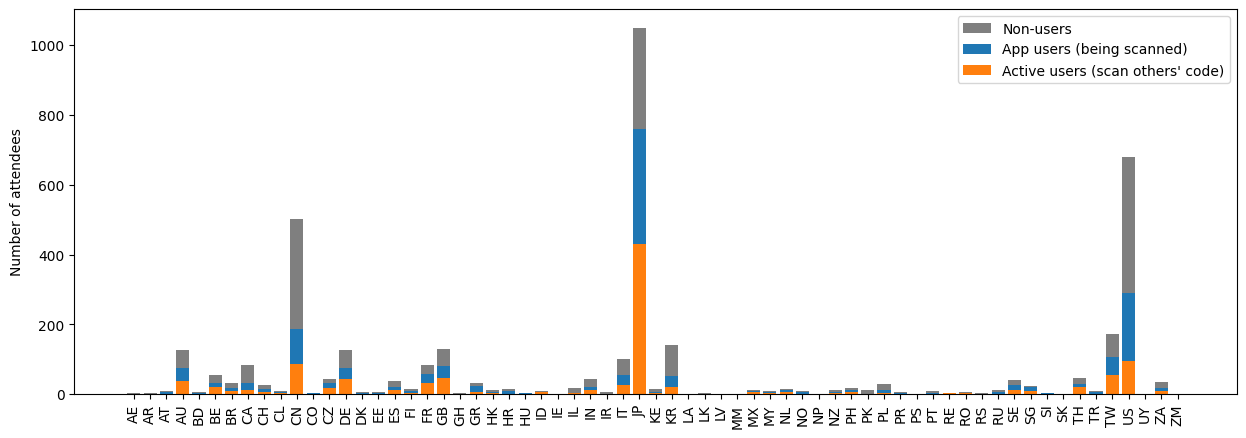

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(df_attendee_counts.index, df_attendee_counts.attendee_count, label='Non-users', color='tab:gray')
ax.bar(df_attendee_counts.index, df_attendee_counts.user_count, label='App users (being scanned)', color='tab:blue')
ax.bar(df_attendee_counts.index, df_attendee_counts.active_user_count, label="Active users (scan others' code)", color='tab:orange')
#turn ticks labels 90°
ax.set_xticklabels(df_attendee_counts.index, rotation=90)
ax.legend()
ax.set_ylabel('Number of attendees')
fig.show()
fig.savefig("count_country.svg")

## Field category (Figure S1C)

In [ ]:
category = "field_name"
attendee_counts = df_attendees[category].value_counts()

appUsers = df_connections.from_person.unique()
df_appUsers = df_attendees[df_attendees.attendee_id.isin(appUsers)]
appUsers_counts = df_appUsers[category].value_counts()

activeUsers = df_connections[df_connections.forward].from_person.unique()
df_activeUsers = df_attendees[df_attendees.attendee_id.isin(activeUsers)]
activeUsers_counts = df_activeUsers[category].value_counts()

df_attendee_counts = pd.DataFrame({'attendee_count': attendee_counts.values}, index=attendee_counts.index)
df_attendee_counts = df_attendee_counts.join(appUsers_counts.rename("user_count"), how='outer')
df_attendee_counts = df_attendee_counts.join(activeUsers_counts.rename("active_user_count"), how='outer')
df_attendee_counts = df_attendee_counts.fillna(0)
#df_attendee_counts

<ipython-input-91-ae8dbf95289a>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_attendee_counts.index, rotation=90)


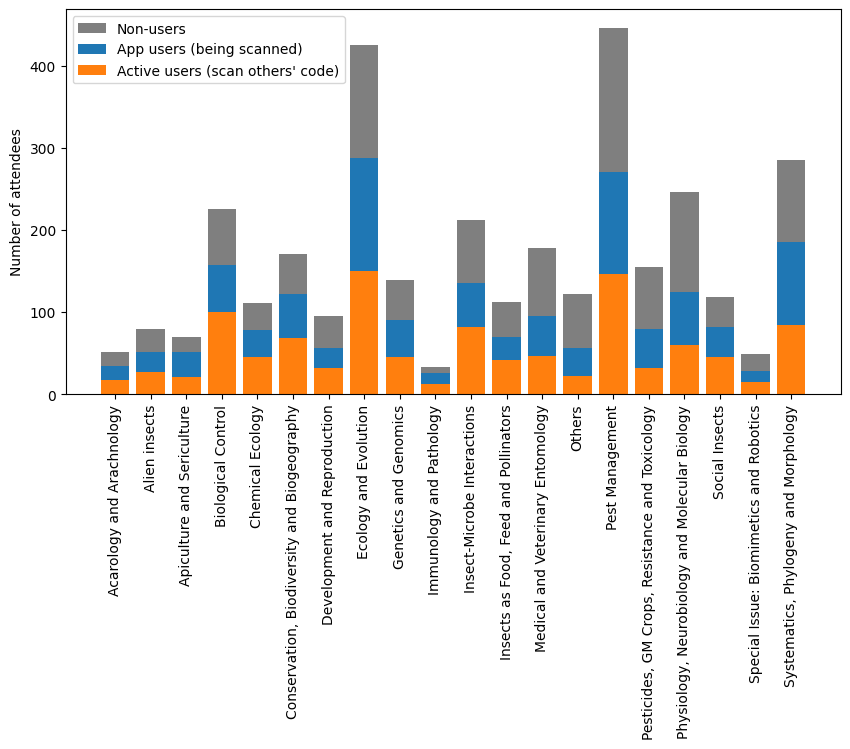

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_attendee_counts.index, df_attendee_counts.attendee_count, label='Non-users', color='tab:gray')
ax.bar(df_attendee_counts.index, df_attendee_counts.user_count, label='App users (being scanned)', color='tab:blue')
ax.bar(df_attendee_counts.index, df_attendee_counts.active_user_count, label="Active users (scan others' code)", color='tab:orange')
#x軸のメモリを90度回転
ax.set_xticklabels(df_attendee_counts.index, rotation=90)
ax.legend()
ax.set_ylabel('Number of attendees')
fig.show()
fig.savefig("count_field.svg")

## Academic roles (Figure S1B)

In [ ]:
category = "attend_as"
attendee_counts = df_attendees[category].value_counts()

appUsers = df_connections.from_person.unique()
df_appUsers = df_attendees[df_attendees.attendee_id.isin(appUsers)]
appUsers_counts = df_appUsers[category].value_counts()

activeUsers = df_connections[df_connections.forward].from_person.unique()
df_activeUsers = df_attendees[df_attendees.attendee_id.isin(activeUsers)]
activeUsers_counts = df_activeUsers[category].value_counts()

df_attendee_counts = pd.DataFrame({'attendee_count': attendee_counts.values}, index=attendee_counts.index)
df_attendee_counts = df_attendee_counts.join(appUsers_counts.rename("user_count"), how='outer')
df_attendee_counts = df_attendee_counts.join(activeUsers_counts.rename("active_user_count"), how='outer')
df_attendee_counts = df_attendee_counts.fillna(0)
#df_attendee_counts

<ipython-input-93-ce11e7d4f387>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_attendee_counts.index, rotation=90)


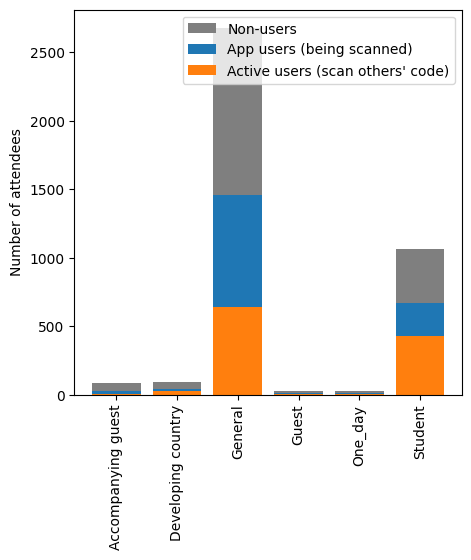

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(df_attendee_counts.index, df_attendee_counts.attendee_count, label='Non-users', color='tab:gray')
ax.bar(df_attendee_counts.index, df_attendee_counts.user_count, label='App users (being scanned)', color='tab:blue')
ax.bar(df_attendee_counts.index, df_attendee_counts.active_user_count, label="Active users (scan others' code)", color='tab:orange')
#x軸のメモリを90度回転
ax.set_xticklabels(df_attendee_counts.index, rotation=90)
ax.legend()
ax.set_ylabel('Number of attendees')
fig.show()

In [ ]:
df_attendee_counts["student"] = df_attendee_counts.index == "Student"
df_student_or_not = df_attendee_counts.groupby("student").sum()
df_student_or_not = df_student_or_not.rename({False: "non-student", True: "student"})
df_student_or_not

,attendee_count,user_count,active_user_count
student,,,
non-student,2907,1544,683
student,1063,672,429


<ipython-input-95-97a278325915>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_student_or_not.index, rotation=90)


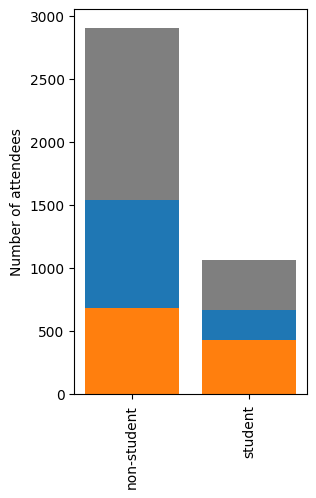

In [ ]:
fig, ax = plt.subplots(figsize=(3, 5))
ax.bar(df_student_or_not.index, df_student_or_not.attendee_count, label='Non-users', color='tab:gray')
ax.bar(df_student_or_not.index, df_student_or_not.user_count, label='App users (being scanned)', color='tab:blue')
ax.bar(df_student_or_not.index, df_student_or_not.active_user_count, label="Active users (scan others' code)", color='tab:orange')
#x軸のメモリを90度回転
ax.set_xticklabels(df_student_or_not.index, rotation=90)
#ax.legend()
ax.set_ylabel('Number of attendees')
fig.show()
fig.savefig("count_student_or_not.svg")

# Metrics of the whole network

## Summary of the network (Table 1)

In [ ]:
# The number of interactions (without double-counting the reverse direction)
print(f"Total number of interactions: {len(df_connections[df_connections.forward])}")

# Number of users who had access for the app
print(f"Total number of registered users: {len(df_attendees.attendee_id.unique())}")

# Number of users
print(f"Total number of users: {len(df_connections.from_person.unique())}")

# Number of active users
print(f"Total number of active users: {len(df_connections[df_connections.forward].from_person.unique())}")

Total number of interactions: 7512
Total number of registered users: 3972
Total number of users: 2216
Total number of active users: 1112


In [ ]:
# Feature values of the network
mcc = nx.average_clustering(G)
print(f"mean cluster coefficient: {mcc}")
print(f"degree correlation", "{:.3f}".format(nx.degree_pearson_correlation_coefficient(G)))

G_connected_components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
for G_connected_component in G_connected_components:
  print(f"radius: {nx.radius(G_connected_component)}",
        f"diameter: {nx.diameter(G_connected_component)}",
        f"average path length: {nx.average_shortest_path_length(G_connected_component)}",
        f"number of nodes: {G_connected_component.number_of_nodes()}",
        f"number of edges: {G_connected_component.number_of_edges()}",
        )

mean cluster coefficient: 0.18165144988099252
degree correlation -0.098
radius: 5 diameter: 9 average path length: 3.823944591435849 number of nodes: 2206 number of edges: 7507
radius: 1 diameter: 1 average path length: 1.0 number of nodes: 2 number of edges: 1
radius: 1 diameter: 1 average path length: 1.0 number of nodes: 2 number of edges: 1
radius: 1 diameter: 1 average path length: 1.0 number of nodes: 2 number of edges: 1
radius: 1 diameter: 1 average path length: 1.0 number of nodes: 2 number of edges: 1
radius: 1 diameter: 1 average path length: 1.0 number of nodes: 2 number of edges: 1


== All users ======
Total connection count (doublecounting reverse direction): 15024
Average degree: 6.7797833935018055
Max degree: 164
Min degree: 1
Stdev of degree: 10.905620183081307
== Active users ======
Total connection count (doublecounting reverse direction): 12191
Average degree: 10.963129496402878
Max degree: 164
Min degree: 1
Stdev of degree: 14.056076296525083


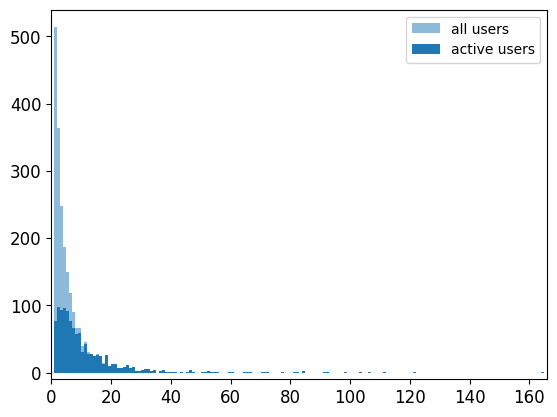

In [ ]:
df_connections_forward = df_connections[df_connections.forward].copy()
upper_limit = 200
bin_width = 1
degree_counts = []
connection_person_list = list(df_connections.from_person)
for person in df_connections.from_person.unique():
  degree = connection_person_list.count(person)
  degree_counts.append(degree)

degree_counts_active_user = []
for person in df_connections_forward.from_person.unique():
  degree = connection_person_list.count(person)
  degree_counts_active_user.append(degree)

fig, ax = plt.subplots()
ax.hist(degree_counts,
        bins=(np.array(range(min(degree_counts), max(degree_counts)+ 2 * bin_width, bin_width))),
        color="tab:blue",
        alpha=0.5,
        label="all users")

ax.hist(degree_counts_active_user,
        bins=(np.array(range(min(degree_counts_active_user), max(degree_counts_active_user)+ 2 * bin_width, bin_width))),
        color="tab:blue",
        label="active users")

ax.set_xlim(0, min(upper_limit, max(degree_counts)+ 2 * bin_width))
ax.set_ylim(-10)
ax.tick_params(labelsize =12)
ax.legend()
fig.patch.set_alpha(0)
fig.show()
fig.savefig("degree_distribution.pdf")
fig.savefig("degree_distribution.svg")


print("== All users ======")
print(f"Total connection count (doublecounting reverse direction): {sum(degree_counts)}")
print(f"Average degree: {sum(degree_counts)/len(degree_counts)}")
print(f"Max degree: {max(degree_counts)}")
print(f"Min degree: {min(degree_counts)}")
print(f"Stdev of degree: {np.std(degree_counts)}")

print("== Active users ======")
print(f"Total connection count (doublecounting reverse direction): {sum(degree_counts_active_user)}")
print(f"Average degree: {sum(degree_counts_active_user)/len(degree_counts_active_user)}")
print(f"Max degree: {max(degree_counts_active_user)}")
print(f"Min degree: {min(degree_counts_active_user)}")
print(f"Stdev of degree: {np.std(degree_counts_active_user)}")

## Count of interactions through time

In [ ]:
start_date = "2024-08-25"#@param {type:"date"}
start_time = "00:00"#@param {type:"string"}

end_datetime = "2024-08-31"#@param {type:"date"}
end_time = "0:00"#@param {type:"string"}

start_datetime = f"{start_date}T{start_time}"
start_datetime = datetime.datetime.strptime(start_datetime, "%Y-%m-%dT%H:%M")
end_datetime = f"{end_datetime}T{end_time}"
end_datetime = datetime.datetime.strptime(end_datetime, "%Y-%m-%dT%H:%M")

### Define events, sessions, and function for visualising them

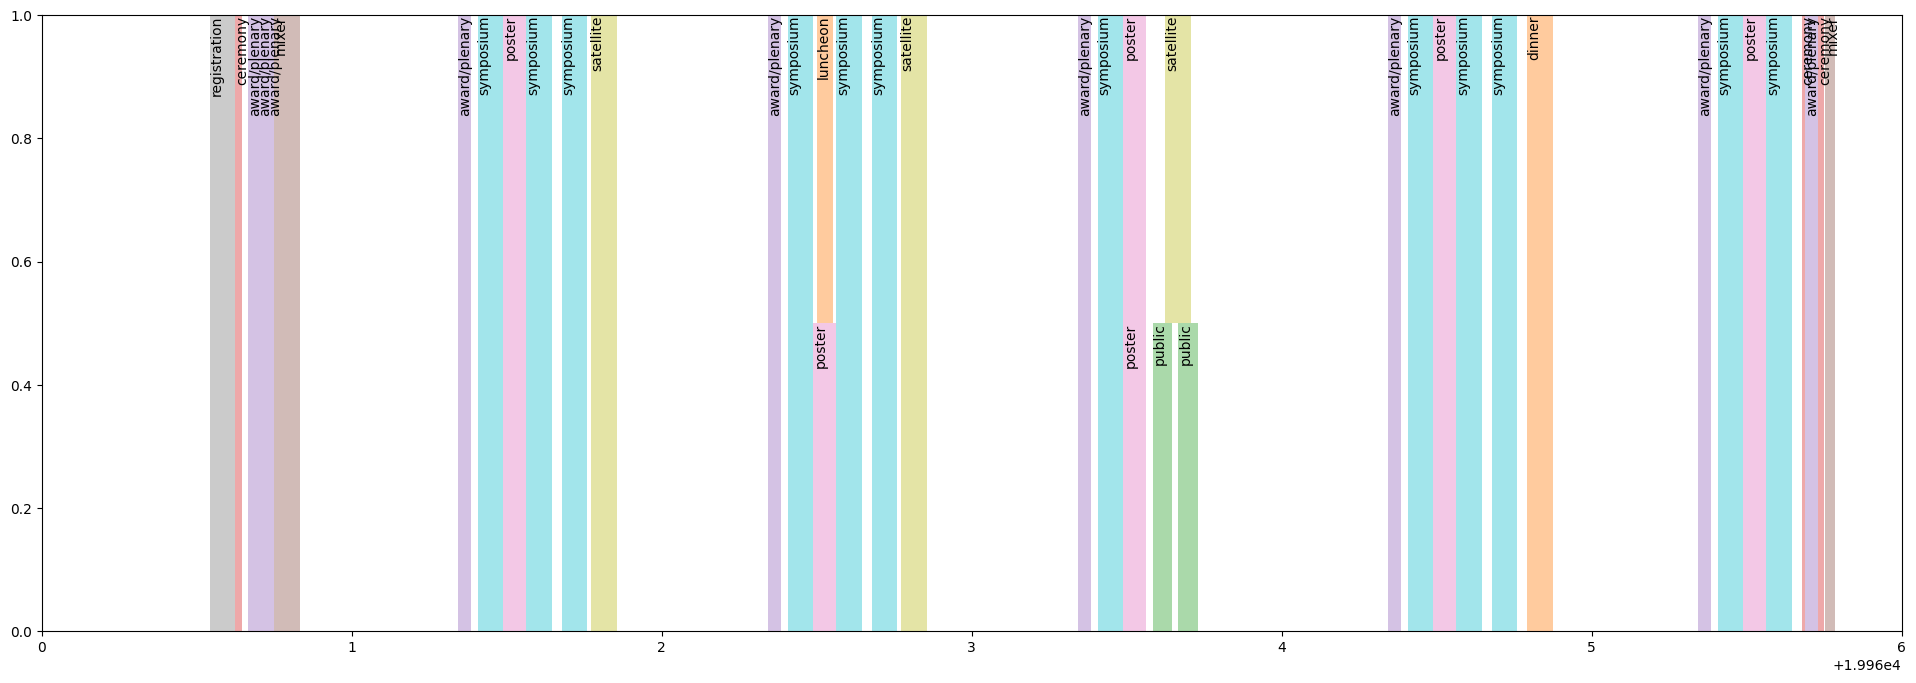

In [ ]:
events_data = [
    # Sunday 25 Aug
    {"name": "Reception", "start": "2024-08-25 13:00", "end": "2024-08-25 15:00", "event_type": "registration"},
    {"name": "Opening Ceremony", "start": "2024-08-25 15:00", "end": "2024-08-25 15:30", "event_type": "ceremony"},
    {"name": "The Wigglesworth Memorial Lecture and Award Ceremony", "start": "2024-08-25 16:00", "end": "2024-08-25 16:45", "event_type": "award/plenary"},
    {"name": "The Filipo Silvestri Memorial Lecture and Award Ceremony", "start": "2024-08-25 16:45", "end": "2024-08-25 17:30", "event_type": "award/plenary"},
    {"name": "Award Ceremony for Certificate of Distinction and Certificate of Merit", "start": "2024-08-25 17:30", "end": "2024-08-25 18:00", "event_type": "award/plenary"},
    {"name": "Welcome Mixer", "start": "2024-08-25 18:00", "end": "2024-08-25 20:00", "event_type": "mixer"},

    # Monday 26 Aug
    {"name": "Plenary Lecture 1: Nancy A. Moran", "start": "2024-08-26 08:15", "end": "2024-08-26 09:15", "event_type": "award/plenary"},
    {"name": "Symposium Mon 1", "start": "2024-08-26 09:45", "end": "2024-08-26 11:45", "event_type": "symposium"},
    {"name": "Poster Presentation", "start": "2024-08-26 11:45", "end": "2024-08-26 13:30", "event_type": "poster"},
    {"name": "Symposium Mon 2", "start": "2024-08-26 13:30", "end": "2024-08-26 15:30", "event_type": "symposium"},
    {"name": "Symposium Mon 3", "start": "2024-08-26 16:15", "end": "2024-08-26 18:15", "event_type": "symposium"},
    {"name": "Satellite Symposium 1, 2", "start": "2024-08-26 18:30", "end": "2024-08-26 20:30", "event_type": "satellite"},

    # Tuesday 27 Aug
    {"name": "Plenary Lecture 2: Fredrik Ronquist", "start": "2024-08-27 08:15", "end": "2024-08-27 09:15", "event_type": "award/plenary"},
    {"name": "Symposium Tue 1", "start": "2024-08-27 09:45", "end": "2024-08-27 11:45", "event_type": "symposium"},
    {"name": "Poster Presentation", "start": "2024-08-27 11:45", "end": "2024-08-27 13:30", "event_type": "poster", "position": "left"},
    {"name": "Women in Entomology Luncheon Seminar", "start": "2024-08-27 12:00", "end": "2024-08-27 13:15", "event_type": "luncheon", "position": "right"},
    {"name": "Symposium Tue 2", "start": "2024-08-27 13:30", "end": "2024-08-27 15:30", "event_type": "symposium"},
    {"name": "Symposium Tue 3", "start": "2024-08-27 16:15", "end": "2024-08-27 18:15", "event_type": "symposium"},
    {"name": "Satellite Symposium 3, 4", "start": "2024-08-27 18:30", "end": "2024-08-27 20:30", "event_type": "satellite"},

    # Wednesday 28 Aug
    {"name": "Plenary Lecture 3: Yupa Hanboonsong", "start": "2024-08-28 08:15", "end": "2024-08-28 09:15", "event_type": "award/plenary"},
    {"name": "Symposium Wed 1", "start": "2024-08-28 09:45", "end": "2024-08-28 11:45", "event_type": "symposium"},
    {"name": "Poster Presentation", "start": "2024-08-28 11:45", "end": "2024-08-28 13:30", "event_type": "poster", "position": "left"},
    {"name": "Poster Presentation by Elementary, Junior High and Senior High School Students", "start": "2024-08-28 11:45", "end": "2024-08-28 13:30", "event_type": "poster", "position": "right"},
    {"name": "Women in Entomology Lecture (Open to Public)", "start": "2024-08-28 14:00", "end": "2024-08-28 15:30", "event_type": "public", "position": "left"},
    {"name": "Satellite Symposium 5", "start": "2024-08-28 15:00", "end": "2024-08-28 17:00", "event_type": "satellite", "position": "right"},
    {"name": "Citizen Program (Open to Public)", "start": "2024-08-28 16:00", "end": "2024-08-28 17:30", "event_type": "public", "position": "left"},

    # Thursday 29 Aug
    {"name": "Plenary Lecture 4: Juan C. Corley", "start": "2024-08-29 08:15", "end": "2024-08-29 09:15", "event_type": "award/plenary"},
    {"name": "Symposium Thu 1", "start": "2024-08-29 09:45", "end": "2024-08-29 11:45", "event_type": "symposium"},
    {"name": "Poster Presentation", "start": "2024-08-29 11:45", "end": "2024-08-29 13:30", "event_type": "poster"},
    {"name": "Symposium Thu 2", "start": "2024-08-29 13:30", "end": "2024-08-29 15:30", "event_type": "symposium"},
    {"name": "Symposium Thu 3", "start": "2024-08-29 16:15", "end": "2024-08-29 18:15", "event_type": "symposium"},
    {"name": "Gala Dinner @ The Prince Kyoto Takaragaike", "start": "2024-08-29 19:00", "end": "2024-08-29 21:00", "event_type": "dinner"},

    # Friday 30 Aug
    {"name": "Plenary Lecture 5: Rosemary Sang", "start": "2024-08-30 08:15", "end": "2024-08-30 09:15", "event_type": "award/plenary"},
    {"name": "Symposium Fri 1", "start": "2024-08-30 09:45", "end": "2024-08-30 11:45", "event_type": "symposium"},
    {"name": "Poster Presentation", "start": "2024-08-30 11:45", "end": "2024-08-30 13:30", "event_type": "poster"},
    {"name": "Symposium Fri 2", "start": "2024-08-30 13:30", "end": "2024-08-30 15:30", "event_type": "symposium"},
    {"name": "Special Movie", "start": "2024-08-30 16:15", "end": "2024-08-30 16:30", "event_type": "ceremony"},
    {"name": "Plenary Lecture 6: Ryohei Kanzaki", "start": "2024-08-30 16:30", "end": "2024-08-30 17:30", "event_type": "award/plenary"},
    {"name": "Closing Ceremony", "start": "2024-08-30 17:30", "end": "2024-08-30 18:00", "event_type": "ceremony"},
    {"name": "Farewell Mixer", "start": "2024-08-30 18:05", "end": "2024-08-30 18:50", "event_type": "mixer"},
]

color_for_event_type = {
    "symposium": "tab:cyan",
    "poster": "tab:pink",
    "award/plenary": "tab:purple",
    "ceremony": "tab:red",
    "mixer": "tab:brown",
    "public": "tab:green",
    "satellite": "tab:olive",
    "dinner": "tab:orange",
    "luncheon": "tab:orange"
}

df_events = pd.DataFrame(events_data)
df_events["start"] = pd.to_datetime(df_events["start"])
df_events["end"] = pd.to_datetime(df_events["end"])

def draw_events(ax, df_events, scale=1, annotate="event_type", alpha=0.5):
  rectangles = []
  for key, row in df_events.iterrows():
    if row.position == "left":
      top = 0.5
      bottom = 0
    elif row.position == "right":
      top = 1
      bottom = 0.5
    else:
      top = 1
      bottom = 0
    height = (top - bottom) * scale
    bottom = bottom * scale
    top = top * scale
    rectangle = patches.Rectangle((row.start, bottom), width=row.end - row.start, height=height, alpha=alpha)
    rectangle.set_facecolor(color_for_event_type.get(row.event_type, "tab:gray"))
    rectangles.append(rectangle)

    ax.annotate(row[annotate], (row.start, top), rotation=90, va="top")

  for rectangle in rectangles:
    ax.add_patch(rectangle)

# Test draw
fig, ax = plt.subplots(figsize=(24, 8))
draw_events(ax, df_events=df_events, alpha=0.4)
ax.set_xlim(start_datetime, end_datetime)
fig.show()

### Show moving average of interaction count through time (Figure 2A)

In [ ]:
# Define function for calculating moving average
def weighted_moving_average(df, column, start_datetime, end_datetime, window_size_minutes=15, frequency="5min"):
  # make index of time
  time_index = pd.date_range(start=start_datetime, end=end_datetime, freq=frequency)
  result_df = pd.DataFrame(index=time_index)

  # convert window size into seconds
  window_size_seconds = window_size_minutes * 60

  # set sigma
  std_dev_seconds = window_size_seconds

  # convert time index into seconds
  time_index_seconds = time_index.astype(np.int64) // 10**9

  for t in tqdm(time_index_seconds):
    # weight based on gaussian
    weights = norm.pdf((df.index.astype(np.int64) // 10**9 - t) / std_dev_seconds)
    # weighted values
    weighted_values = df[column] * weights

    # weighted moving average
    result_df.loc[pd.Timestamp(t, unit='s'), 'weighted_mean'] = np.sum(weighted_values)
  return result_df

#### Number of interaction

In [ ]:
# Copy and arrange data
df_for_moving_average = df_connections[df_connections.forward].copy()
df_for_moving_average = df_for_moving_average[df_for_moving_average.timestamp_datetime >= start_datetime].copy()
df_for_moving_average = df_for_moving_average[df_for_moving_average.timestamp_datetime <= end_datetime].copy()
df_for_moving_average.set_index("timestamp_datetime", inplace=True)
df_for_moving_average["count"] = 1

weighted_mean_count = weighted_moving_average(df_for_moving_average, 'count', start_datetime, end_datetime, frequency="1min", window_size_minutes=3)

100%|██████████| 8641/8641 [00:14<00:00, 614.74it/s]


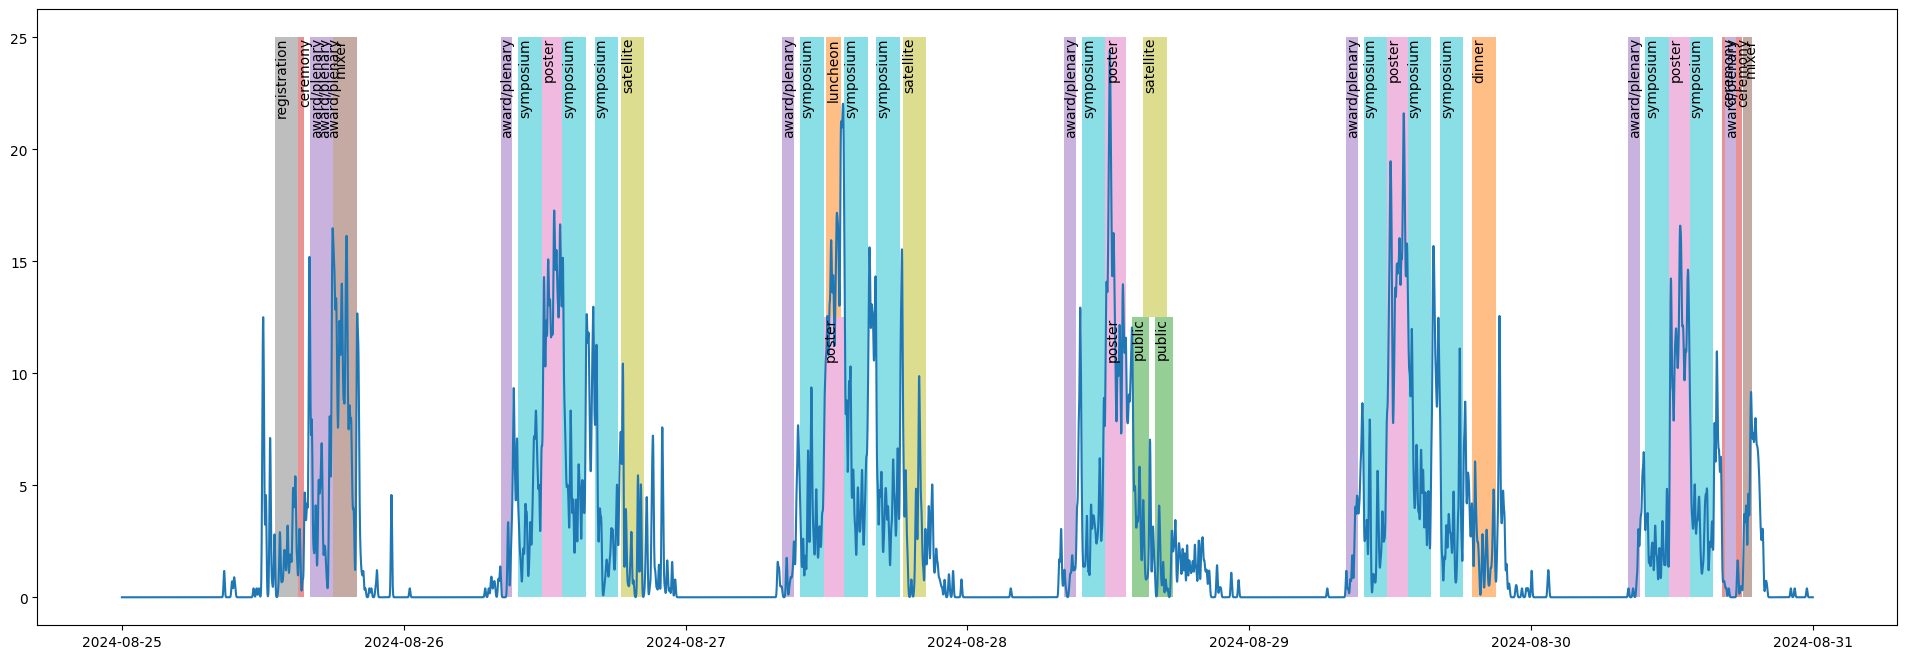

In [ ]:
# Draw graph
fig, ax = plt.subplots(figsize=(24, 8))
ax.plot(weighted_mean_count.index, weighted_mean_count.weighted_mean)
draw_events(ax, df_events, scale=25, annotate="event_type", alpha=0.5)
fig.show()
fig.savefig("moving_average_count.pdf")
fig.savefig("moving_average_count.svg")


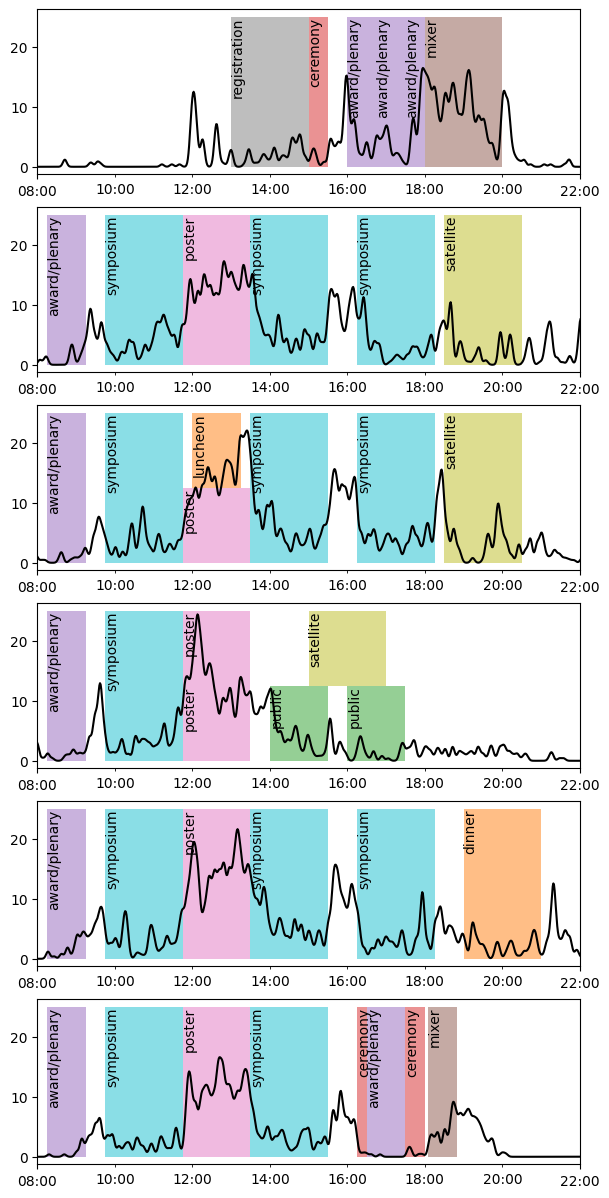

In [ ]:
# Draw each day separately
day_range = list(range(25, 31))
fig, axes = plt.subplots(len(day_range), 1, figsize=(7, 15), sharey=True)
i = 0
for day in day_range:
  ax = axes[i]
  start = datetime.datetime(2024, 8, day, 8, 0)
  end = datetime.datetime(2024, 8, day, 22, 0)
  #end = start + datetime.timedelta(hours=24)
  draw_events(ax, df_events, scale=25, annotate="event_type")
  weighted_mean_count.weighted_mean.plot(ax=ax, legend=False, zorder=100, color="black")
  ax.set_xlim(start, end)
  i = i + 1
fig.patch.set_alpha(0)
fig.show()
fig.savefig("moving_average_count_each_day.pdf")
fig.savefig("moving_average_count_each_day.svg")


#### Number and ratio of international interaction (Figure 2C)

In [ ]:
# get weighted mean for all connections
weighted_mean_all = weighted_moving_average(df_for_moving_average, 'count', start_datetime, end_datetime, frequency="2min", window_size_minutes=15)
weighted_mean_all.columns = ["all_connection"]

# get weighted mean for international connections
df_for_moving_average["different_country"] = df_for_moving_average.from_country != df_for_moving_average.to_country
weighted_mean_different_country = weighted_moving_average(df_for_moving_average, 'different_country', start_datetime, end_datetime, frequency="2min", window_size_minutes=15)
weighted_mean_different_country.columns = ["different_country"]

# concatenate into one dataframe
weighted_mean = pd.concat([weighted_mean_all, weighted_mean_different_country], axis=1)
weighted_mean["ratio"] = weighted_mean.different_country / weighted_mean.all_connection

# calculate bayesian confedence intervals of the ratio
intervals = [50, 90, 95]
for interval in intervals:
  df_interval_different_country = weighted_mean.apply(lambda row: binom_confedence(row["different_country"], row["all_connection"] - row["different_country"], interval / 100), axis=1, result_type="expand")
  weighted_mean[f"different_country_lower{str(interval)}"] = df_interval_different_country[0]
  weighted_mean[f"different_country_upper{str(interval)}"] = df_interval_different_country[1]

100%|██████████| 4321/4321 [00:06<00:00, 687.56it/s]


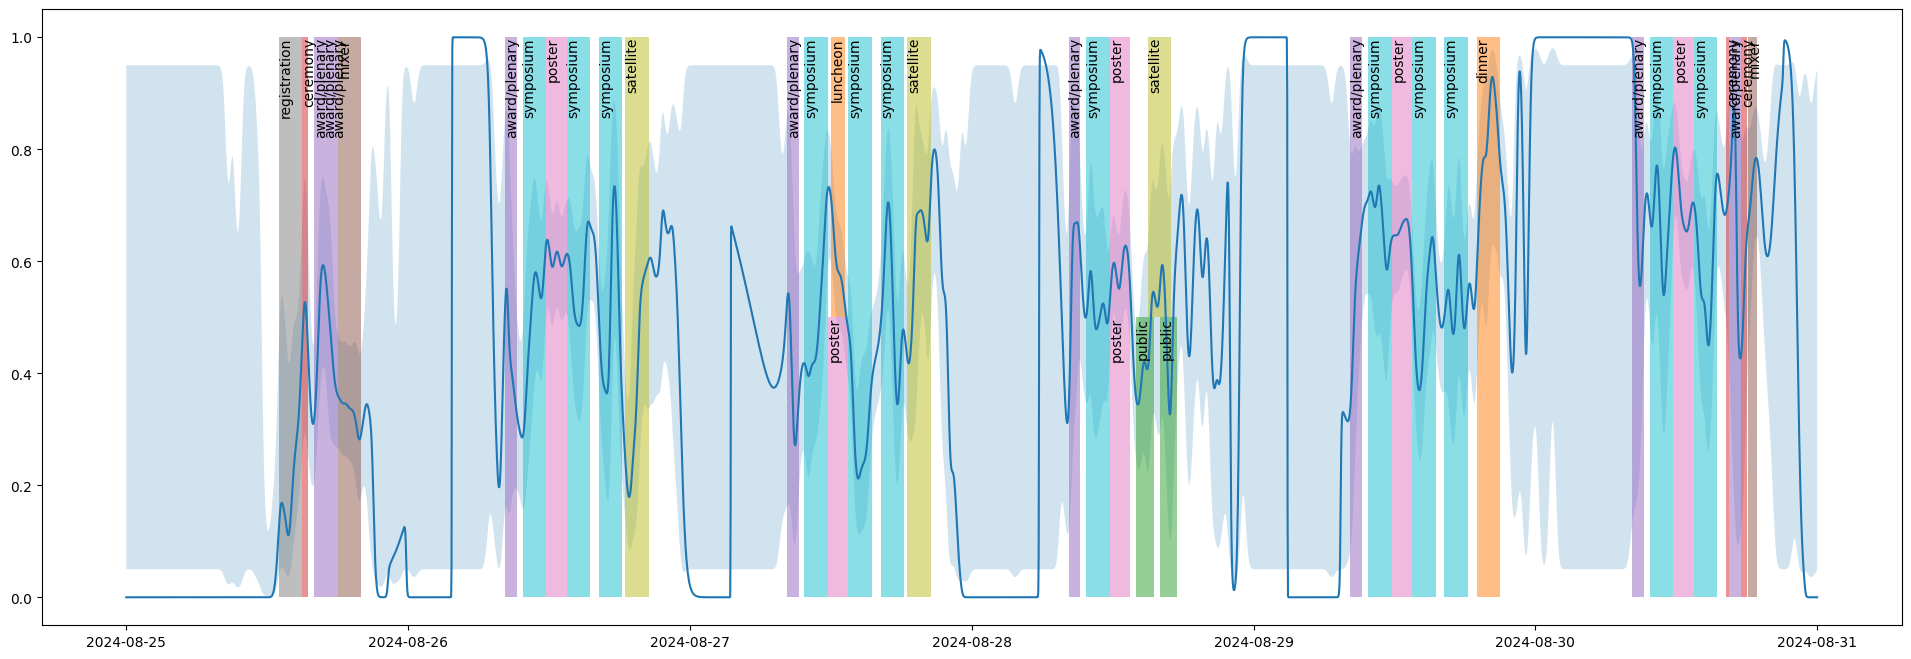

In [ ]:
# draw graph
fig, ax = plt.subplots(figsize=(24, 8))
ax.plot(weighted_mean.index, weighted_mean.ratio)
ax.fill_between(weighted_mean.index, weighted_mean.different_country_lower90, weighted_mean.different_country_upper90, alpha=0.2)
draw_events(ax, df_events, scale=1, annotate="event_type", alpha=0.5)
fig.show()
fig.savefig("international_timeseries_raw.pdf")
fig.savefig("international_timeseries_raw.svg")


<ipython-input-26-5c91e968173b>:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  weighted_mean_filtered.ratio[weighted_mean_filtered.hidden] = np.nan
<ipython-input-26-5c91e968173b>:6: SettingWithCopyWarning: 
A value is trying to be set on 

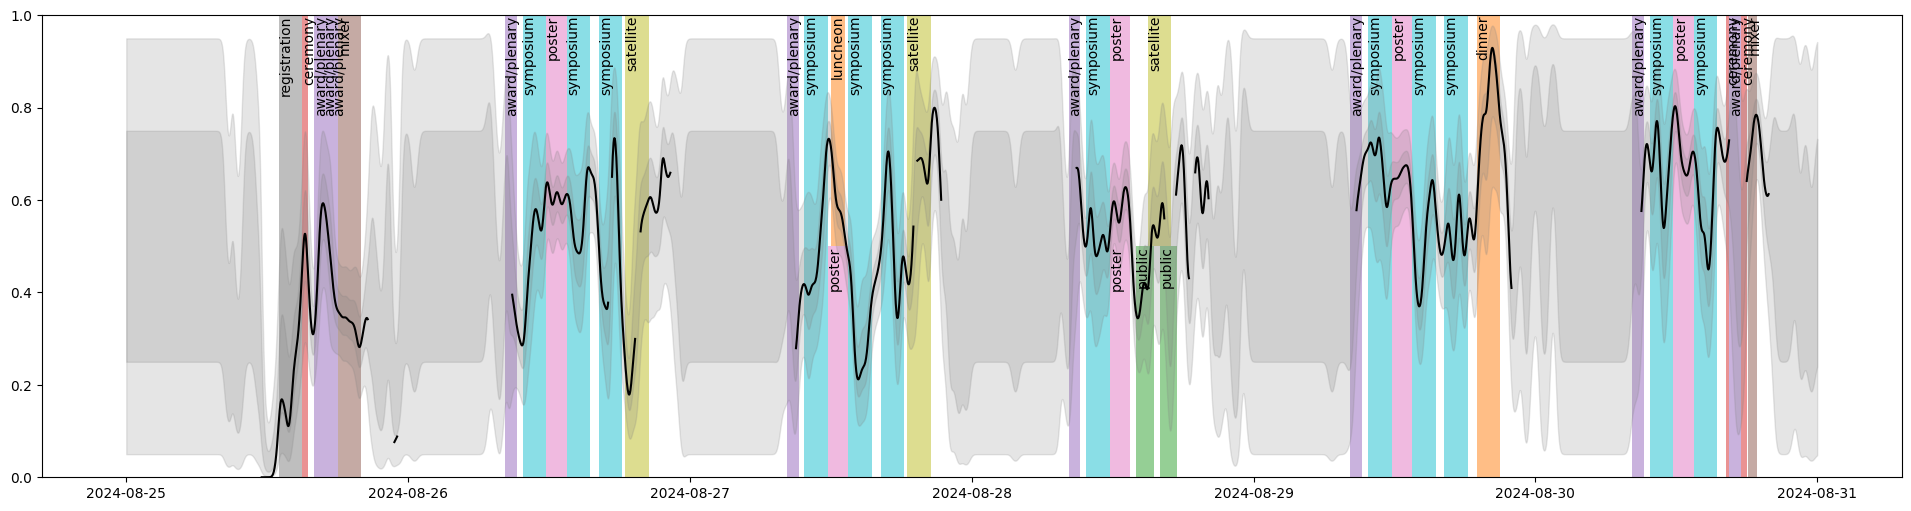

In [ ]:
# draw graph without spans with wide confedence interval range
criteria = 0.5
weighted_mean_filtered = weighted_mean.copy()
weighted_mean_filtered["hidden"] = weighted_mean_filtered.different_country_upper90 - weighted_mean_filtered.different_country_lower90 > criteria
#if hidden is True, fill None into ratio
weighted_mean_filtered.ratio[weighted_mean_filtered.hidden] = np.nan

fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(weighted_mean_filtered.index, weighted_mean_filtered.ratio, color="black")
draw_events(ax, df_events, scale=1, annotate="event_type", alpha=0.5)
ax.fill_between(weighted_mean_filtered.index, weighted_mean_filtered.different_country_lower90, weighted_mean_filtered.different_country_upper90, alpha=0.2, color="gray")
ax.fill_between(weighted_mean_filtered.index, weighted_mean_filtered.different_country_lower50, weighted_mean_filtered.different_country_upper50, alpha=0.2, color="gray")
ax.set_ylim(0,1)
fig.show()
fig.savefig("international_timeseries.pdf")
fig.savefig("international_timeseries.svg")


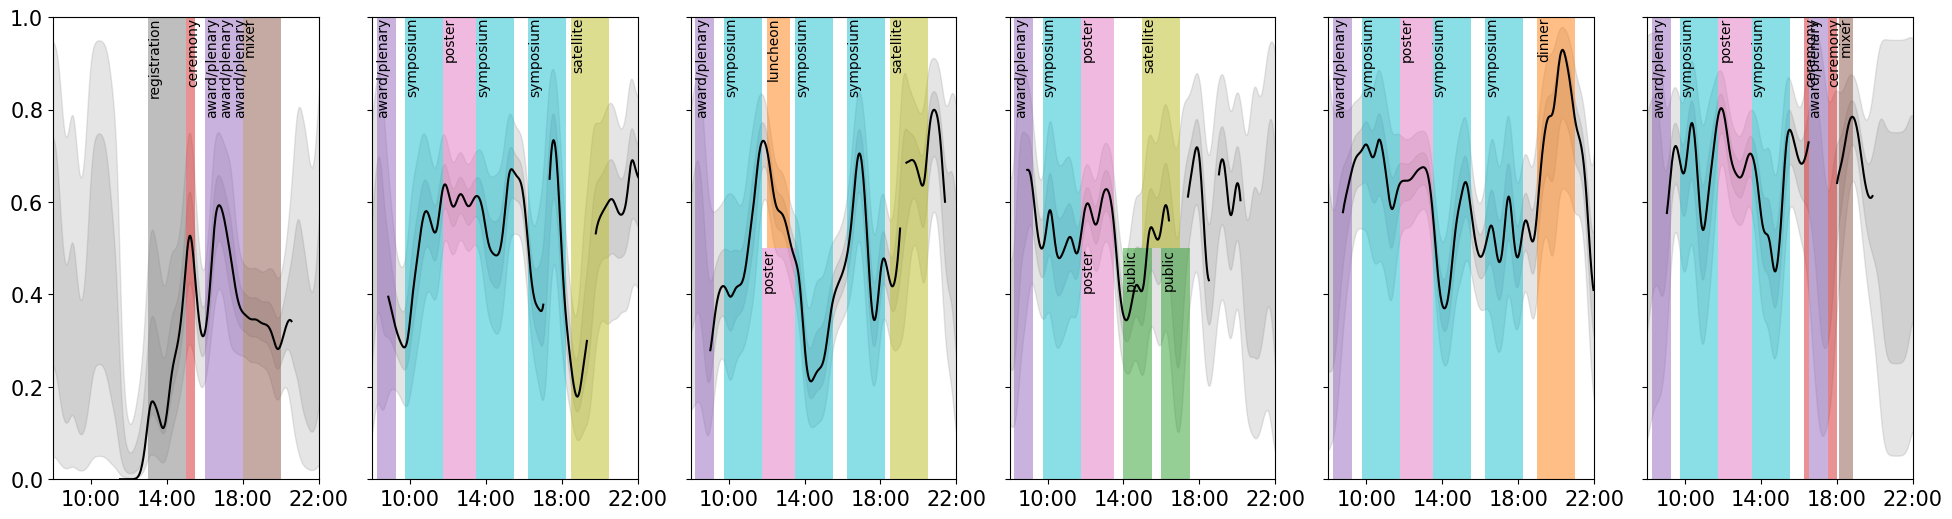

In [ ]:
# Draw each day separately
day_range = list(range(25, 31))
fig, axes = plt.subplots(1, len(day_range), figsize=(24, 6), sharey=True)
i = 0
for day in day_range:
  ax = axes[i]
  start = datetime.datetime(2024, 8, day, 8, 0)
  end = datetime.datetime(2024, 8, day, 22, 0)
  #end = start + datetime.timedelta(hours=24)
  ax.plot(weighted_mean_filtered.index, weighted_mean_filtered.ratio, color="black")
  ax.fill_between(weighted_mean_filtered.index, weighted_mean_filtered.different_country_lower90, weighted_mean_filtered.different_country_upper90, alpha=0.2, color="gray")
  ax.fill_between(weighted_mean_filtered.index, weighted_mean_filtered.different_country_lower50, weighted_mean_filtered.different_country_upper50, alpha=0.2, color="gray")
  draw_events(ax, df_events, scale=1, annotate="event_type")
  ax.set_xlim(start, end)
  ax.set_ylim(0,1)
  #format axhh:mm
  ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
  #ax.xaxis.set_minor_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
  #メモリを8時始まりの4時間区切りに
  ax.xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=4))
  #ax.xaxis.set_minor_locator(plt.matplotlib.dates.HourLocator(interval=1))
  ax.tick_params(axis='x', labelsize=15)
  ax.tick_params(axis='y', labelsize=15)

  i = i + 1
fig.patch.set_alpha(0)
fig.show()
fig.savefig("international_timeseries_each_day.pdf")
fig.savefig("international_timeseries_each_day.svg")

### Statistcal analysis: ratio of international connection through time

#### Simple logistic regression

Optimization terminated successfully.
         Current function value: 0.675028
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      different_country   No. Observations:                 7466
Model:                          Logit   Df Residuals:                     7464
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Jan 2025   Pseudo R-squ.:                 0.02250
Time:                        04:06:36   Log-Likelihood:                -5039.8
converged:                       True   LL-Null:                       -5155.8
Covariance Type:            nonrobust   LLR p-value:                 2.139e-52
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4779      0.047    -10.091      0.000      -0.571      -0.385
timestam

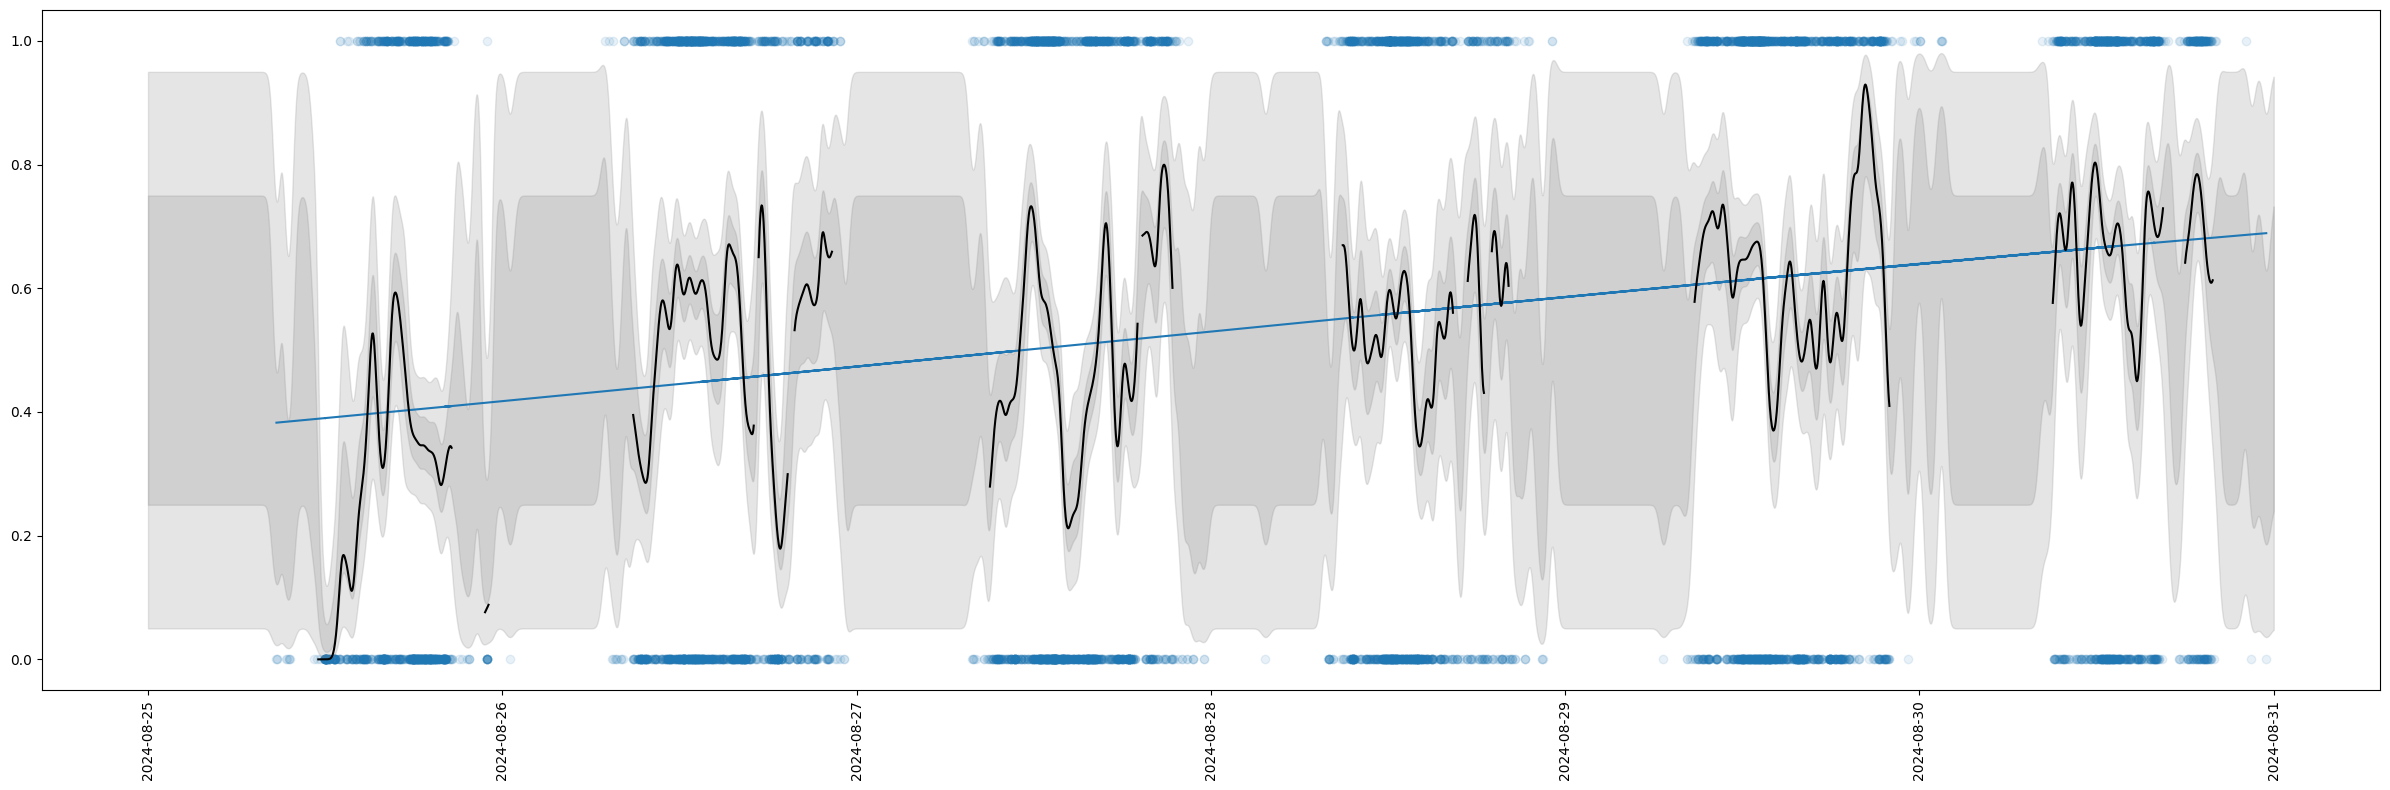

In [ ]:
df_for_logistic = df_for_moving_average.copy()
df_for_logistic["timestamp_numeric"] = (df_for_logistic.index - df_for_logistic.index.min()).total_seconds()
X = sm.add_constant(df_for_logistic['timestamp_numeric'])
y = df_for_logistic['different_country'].astype(int)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

df_for_logistic['predicted_prob'] = result.predict(X)

fig, ax = plt.subplots(figsize=(24, 8))
ax.scatter(df_for_logistic.index, df_for_logistic['different_country'], color='tab:blue', alpha=0.1)
ax.plot(df_for_logistic.index, df_for_logistic['predicted_prob'], color='tab:blue')
ax.plot(weighted_mean_filtered.index, weighted_mean_filtered.ratio, color="black")
ax.fill_between(weighted_mean.index, weighted_mean.different_country_lower90, weighted_mean.different_country_upper90, alpha=0.2, color="gray")
ax.fill_between(weighted_mean.index, weighted_mean.different_country_lower50, weighted_mean.different_country_upper50, alpha=0.2, color="gray")
plt.xticks(rotation=90)
plt.tight_layout()
fig.show()
fig.savefig("international_ratio_timeseries_logistic.pdf")
fig.savefig("international_ratio_timeseries_logistic.svg")


#### Logistic regression with offset

In [ ]:
# To calculate the expected values from null-model (random interaction with no regards of country), aggregate the proportion of each country in each time point
df_for_logistic_offset = df_connections.copy()
df_for_logistic_offset["different_country"] = df_for_logistic_offset.from_country != df_for_logistic_offset.to_country
df_for_logistic_offset = df_for_logistic_offset[df_for_logistic_offset.forward].copy()
for key, row in tqdm(df_for_logistic_offset.iterrows(), total=len(df_for_logistic_offset)):
  df_tmp = df_for_logistic_offset[df_for_logistic_offset.timestamp_datetime <= row.timestamp_datetime].copy()
  list_of_attendees_at_the_time_point = list(set(df_tmp.from_person.tolist() + df_tmp.to_person.tolist()))
  df_attendees_at_the_time_point = df_attendees[df_attendees.attendee_id.isin(list_of_attendees_at_the_time_point)]
  list_of_attendees_at_the_time_point = list(set(df_tmp.from_person.tolist() + df_tmp.to_person.tolist()))
  df_attendees_at_the_time_point = df_attendees[df_attendees.attendee_id.isin(list_of_attendees_at_the_time_point)]
  df_country_count_at_the_time_point = df_attendees_at_the_time_point.groupby("country").count()["attendee_id"]
  country_matrix = pd.DataFrame(np.outer(np.array(df_country_count_at_the_time_point), np.array(df_country_count_at_the_time_point)), columns=df_country_count_at_the_time_point.index, index=df_country_count_at_the_time_point.index)
  possible_connections_at_the_time_point = country_matrix.sum().sum()
  possible_domestic_connections_at_the_time_point = sum([country_matrix.loc[country, country] for country in country_matrix.index])
  possible_international_connections_at_the_time_point = possible_connections_at_the_time_point - possible_domestic_connections_at_the_time_point
  domestic_connections_at_the_time_point = len(df_tmp[~df_tmp.different_country])
  international_connections_at_the_time_point = len(df_tmp) - domestic_connections_at_the_time_point
  left_domestic_connections_at_the_time_point = possible_domestic_connections_at_the_time_point - domestic_connections_at_the_time_point
  left_international_connections_at_the_time_point = possible_international_connections_at_the_time_point - international_connections_at_the_time_point
  df_for_logistic_offset.loc[key, "expected_ratio"] = left_international_connections_at_the_time_point / (left_domestic_connections_at_the_time_point + left_international_connections_at_the_time_point)

df_for_logistic_offset = df_for_logistic_offset[df_for_logistic_offset.timestamp_datetime >= start_datetime].copy()
df_for_logistic_offset = df_for_logistic_offset[df_for_logistic_offset.timestamp_datetime <= end_datetime].copy()
df_for_logistic_offset = df_for_logistic_offset.sort_values("timestamp_datetime")

df_for_logistic_offset.set_index("timestamp_datetime", inplace=True)
df_for_logistic_offset["timestamp_numeric"] = (df_for_logistic_offset.index - df_for_logistic_offset.index.min()).total_seconds()

100%|██████████| 7512/7512 [01:38<00:00, 76.32it/s]


In [ ]:
df_for_logistic_offset["logit_offset"] = np.log(df_for_logistic_offset.expected_ratio / (1 - df_for_logistic_offset.expected_ratio))

X = sm.add_constant(df_for_logistic_offset['timestamp_numeric'])
y = df_for_logistic_offset['different_country'].astype(int)
offset = df_for_logistic_offset["logit_offset"]
model = sm.GLM(
    y,
    X,
    family=sm.families.Binomial(),
    offset=offset
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      different_country   No. Observations:                 7466
Model:                            GLM   Df Residuals:                     7464
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5008.1
Date:                Mon, 06 Jan 2025   Deviance:                       10016.
Time:                        04:08:16   Pearson chi2:                 7.42e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01992
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.9824      0.04

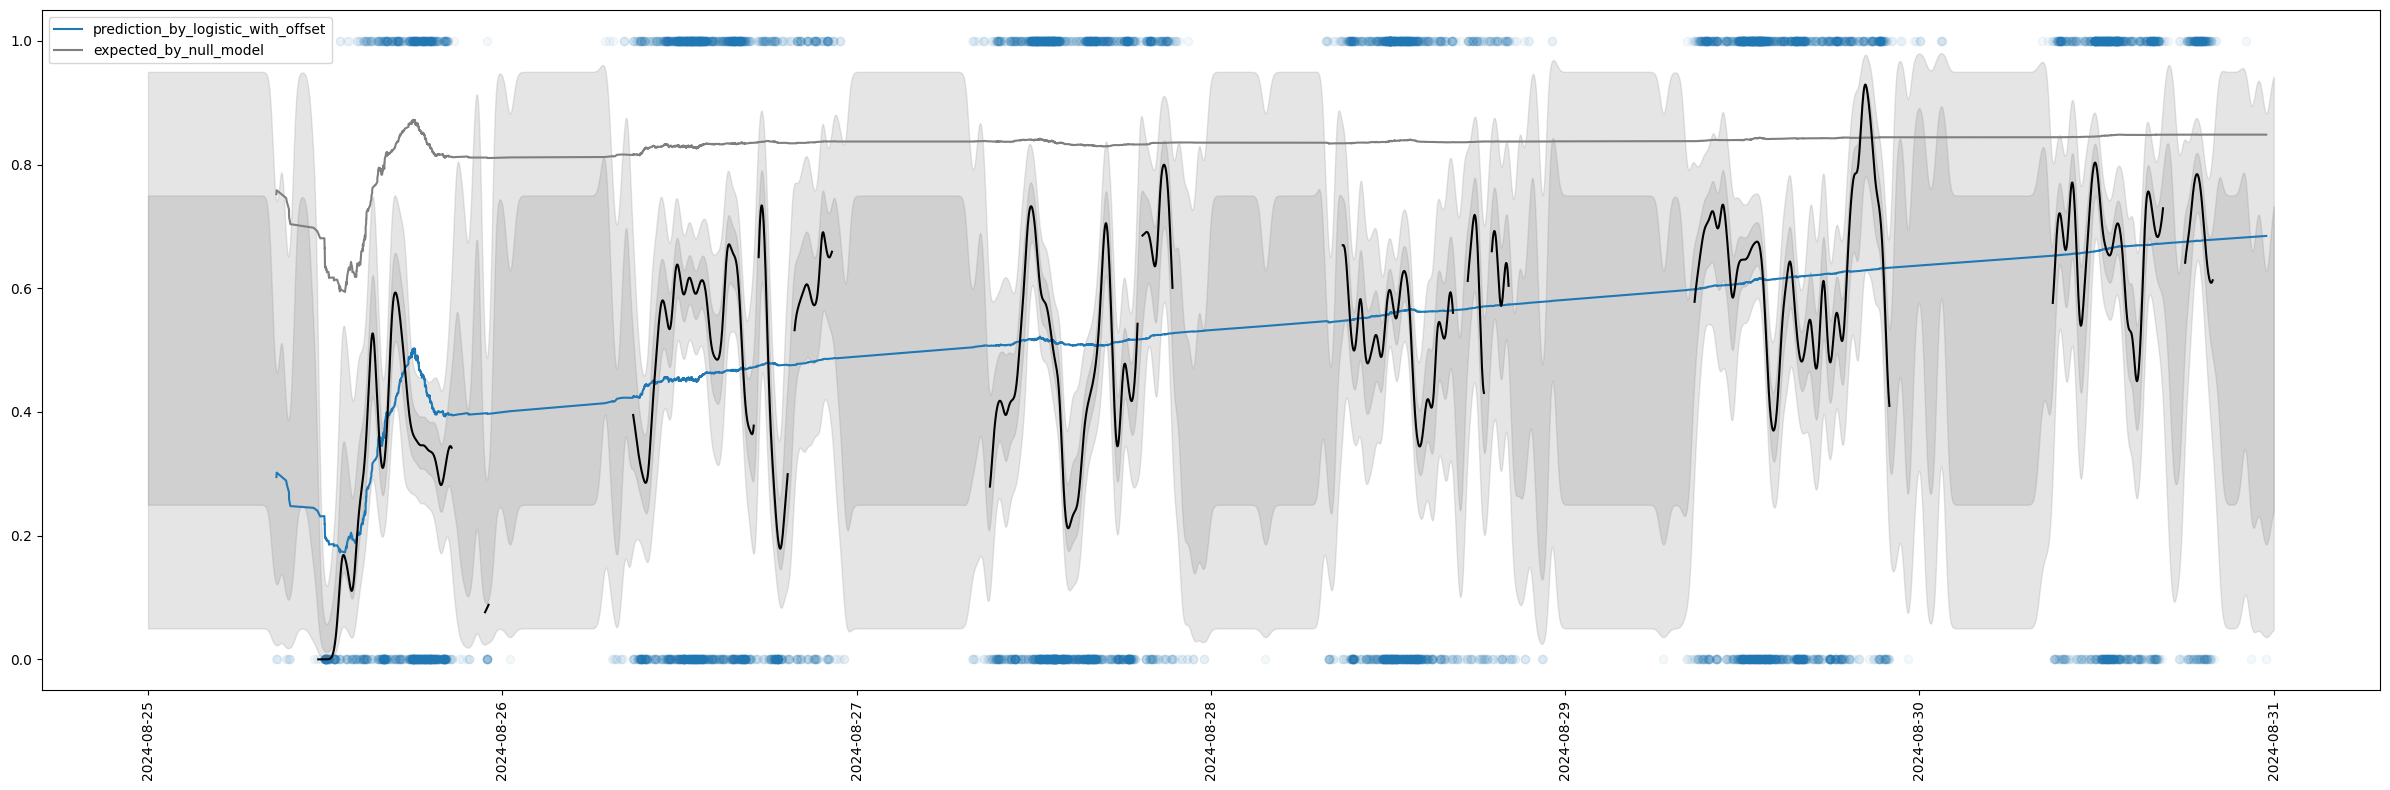

In [ ]:
df_for_logistic_offset['predicted_prob'] = result.predict(X, offset=offset)
fig, ax = plt.subplots(figsize=(24, 8))
ax.scatter(df_for_logistic_offset.index, df_for_logistic_offset['different_country'], color='tab:blue', alpha=0.05)
ax.plot(df_for_logistic_offset.index, df_for_logistic_offset['predicted_prob'], color='tab:blue', label="prediction_by_logistic_with_offset")
ax.plot(df_for_logistic_offset.index, df_for_logistic_offset['expected_ratio'], color='tab:gray', label="expected_by_null_model")

ax.plot(weighted_mean_filtered.index, weighted_mean_filtered.ratio, color="black")
ax.fill_between(weighted_mean.index, weighted_mean.different_country_lower90, weighted_mean.different_country_upper90, alpha=0.2, color="gray")
ax.fill_between(weighted_mean.index, weighted_mean.different_country_lower50, weighted_mean.different_country_upper50, alpha=0.2, color="gray")
plt.xticks(rotation=90)
plt.tight_layout()
ax.legend()
fig.show()
fig.savefig("international_ratio_timeseries_logistic_with_offset.pdf")
fig.savefig("international_ratio_timeseries_logistic_with_offset.svg")

# Analysis based on fields of research

## Metrics of each field category (number of participants, outer and inner connectons)

In [ ]:
df_connections.loc[df_connections.to_field_name.isna(), "to_field_name"] = "Unselected"
df_connections.loc[df_connections.from_field_name.isna(), "from_field_name"] = "Unselected"

field_names = set(df_connections.to_field_name.unique().tolist() + df_connections.from_field_name.unique().tolist())

df_fields = pd.DataFrame(columns=["field_name", "number_of_attendees", "number_of_inner_connections", "number_of_outer_connections", "number_of_connections"])
for field_name in field_names:
  number_of_attendees = len(set(df_connections[df_connections.from_field_name == field_name].from_person.tolist() + df_connections[df_connections.to_field_name == field_name].to_person.tolist() ))
  number_of_inner_connections = len(df_connections[(df_connections.from_field_name == field_name) & (df_connections.to_field_name == field_name)])
  number_of_outer_connections = len(df_connections[(df_connections.from_field_name == field_name) & (df_connections.to_field_name != field_name)])
  number_of_connections = len(df_connections[df_connections.from_field_name == field_name])
  dat = [field_name, number_of_attendees, number_of_inner_connections, number_of_outer_connections, number_of_connections]
  df_fields.loc[len(df_fields)] = dat
df_fields["dominance_of_connections"] = df_fields.number_of_connections / df_fields.number_of_connections.sum()
df_fields["ratio_of_inner_connections"] = df_fields.number_of_inner_connections / df_fields.number_of_connections
df_fields["odds_ratio_of_inner_connections"] = (df_fields.ratio_of_inner_connections / (1 - df_fields.ratio_of_inner_connections)) / (df_fields.dominance_of_connections / (1 - df_fields.dominance_of_connections))

## Aggregate connections for each pair of fields

In [ ]:
field_connection_matrix = df_connections.pivot_table(index="from_field_name", columns="to_field_name", values="connection_id", aggfunc="count").fillna(0)
field_connection_matrix = field_connection_matrix.reindex(field_names, axis=0).reindex(field_names, axis=1)
field_connection_proportion_matrix = field_connection_matrix / field_connection_matrix.sum().sum()
field_expected_frequency_matrix = pd.DataFrame(np.outer(np.array(df_fields.dominance_of_connections), np.array(df_fields.dominance_of_connections)),
                                               columns=df_fields.rename({"field_name": "from_field_name"}, axis=1).from_field_name,
                                               index=df_fields.rename({"field_name": "to_field_name"}, axis=1).to_field_name
                                               )
field_connection_odds_ratio_matrix = (field_connection_proportion_matrix / (1 - field_connection_proportion_matrix)) / (field_expected_frequency_matrix / (1 - field_expected_frequency_matrix))

## Doc2vec

In [ ]:
# Calculate vector for each person (Mean of all vector corresponding to his/her presentation(s))
df_presentation_vector = df_presentations[["presentation_id"] + [f"vector_{i}" for i in range(50)]].set_index("presentation_id").copy()
df_attendee_vector =  df_author_relations.join(df_presentation_vector, on="presentation_id", how="left", rsuffix="_author").copy()
df_attendee_vector = df_attendee_vector[["attendee_id"] + [f"vector_{i}" for i in range(50)]].set_index("attendee_id").copy()
df_attendee_vector = df_attendee_vector.groupby("attendee_id").mean()
df_attendee_vector = pd.merge(df_attendee_vector, df_attendees[["attendee_id", "field"]], on="attendee_id", how="left")
df_attendee_vector["field_name"] = df_attendee_vector.field.map(field_name_dict)
df_attendee_vector.loc[pd.isna(df_attendee_vector.field_name), "field_name"] = "Unselected"
df_attendee_vector = df_attendee_vector.drop("field", axis=1)
df_attendee_vector.set_index("attendee_id", inplace=True)

### Path length in the connection network and similarity of presentation abstract for each individual pair (Figure 3D)

In [ ]:
#relationship between similarity of resarch from person to person and distance in the interaction network
common_nodes = set(df_attendee_vector.index) & set(G.nodes)
node_pairs = [(u, v) for u in common_nodes for v in common_nodes if u != v]

# get vectors from person_vectors_df
person_vectors = df_attendee_vector[[f"vector_{i}" for i in range(50)]].to_numpy()  # person_idに対応するベクトル行列

# calculate cosine similarity of all pairs
cosine_sim_matrix = cosine_similarity(person_vectors)

# lists of distances (path lengths) and similarities
distances = []
cosine_similarities = []

# dictionary to link person id to its index
person_id_to_index = {attendees_id: idx for idx, attendees_id in enumerate(df_attendee_vector.index)}

# for each node pair, calculate the path length on the connection network and the cosine similarity of the presentation abstract
for u, v in tqdm(node_pairs):
    try:
        # Path length on the connection network
        distance = nx.shortest_path_length(G, u, v)
    except nx.NetworkXNoPath:
        distance = 20  # If not connected, set distance=20

    # person_idに基づいてコサイン類似度を取得
    u_idx = person_id_to_index[u]
    v_idx = person_id_to_index[v]
    cosine_similarity_value = cosine_sim_matrix[u_idx, v_idx]

    distances.append(distance)
    cosine_similarities.append(cosine_similarity_value)

100%|██████████| 3369060/3369060 [02:50<00:00, 19775.89it/s]


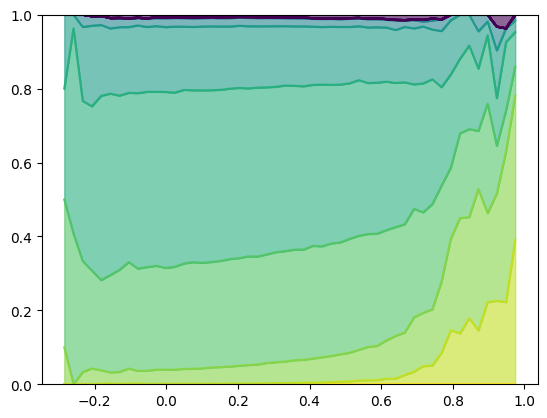

In [ ]:
x = cosine_similarities  # x座標のデータ
y = distances  # y座標のデータ

x_bins = 50
y_bins = np.array(range(22)) - 0.5

# 2次元ヒストグラムを作成
heatmap, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])

#heatmapを、x(cosine similarity)それぞれにおける割合にする
sum_for_each_x = np.sum(heatmap, axis=1, keepdims=True)
heatmap_normalized_for_each_x = heatmap / sum_for_each_x
#積み上げの折れ線グラフ
fig, ax = plt.subplots()

color_map = plt.get_cmap('viridis_r')
n_colors = heatmap_normalized_for_each_x.shape[1]

# 最初の<percentage>%は線形に色を変化させる
percentage = 0.6
linear_colors = color_map(np.linspace(0, 1, int(n_colors * percentage)))
max_color = color_map(1.0)
fixed_colors = np.array([max_color] * (n_colors - int(n_colors * percentage)))
colors = np.vstack((linear_colors, fixed_colors))

tmp_list = np.zeros(heatmap_normalized_for_each_x.shape[0])
for i in range(heatmap_normalized_for_each_x.shape[1]):
  ax.plot(xedges[:-1], tmp_list + heatmap_normalized_for_each_x[:, i], label=f'Y{i+1}', color=colors[i])
  ax.fill_between(xedges[:-1], tmp_list, tmp_list + heatmap_normalized_for_each_x[:, i], alpha=0.6, label=f'Y{i+1}', color=colors[i])
  tmp_list += heatmap_normalized_for_each_x[:, i]
ax.set_ylim(0, 1)
#ax.legend()
fig.show()
fig.savefig("similarity_and_path_length.pdf")
fig.savefig("similarity_and_path_length.svg")


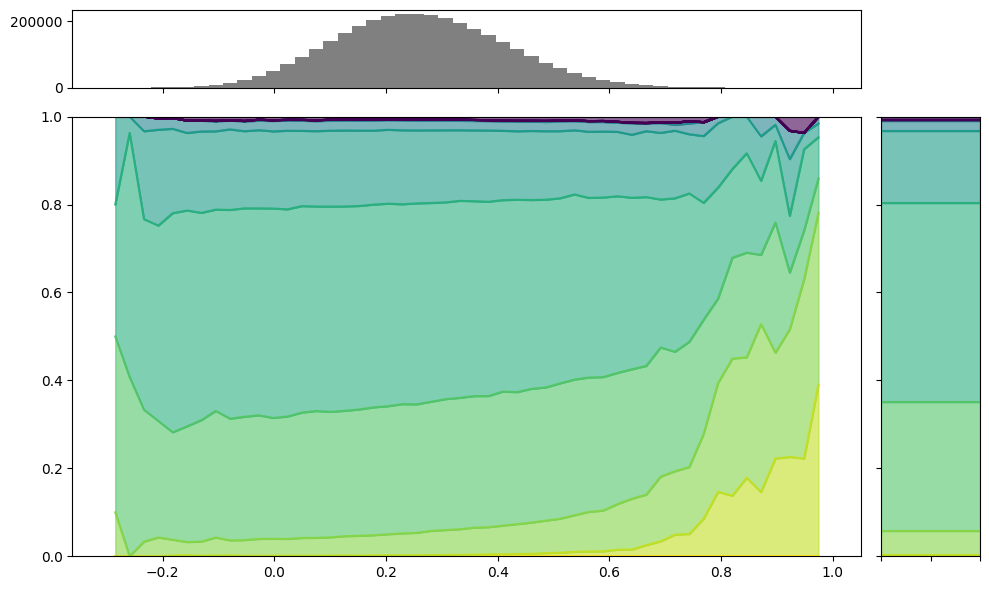

In [ ]:
#yの割合
sum_for_each_y = np.sum(heatmap, axis=0)
sum_for_each_y = sum_for_each_y / np.sum(sum_for_each_y)



## まとめて描画する
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6), layout="tight")
gs = gridspec.GridSpec(2, 2, height_ratios=[0.15, 0.85], width_ratios=[0.8, 0.1])  # 20%と80%に設定

# 各サブプロットをGridSpecで指定
ax1 = fig.add_subplot(gs[0, 0])  # 20%の高さ
ax2 = fig.add_subplot(gs[1, 0], sharex = ax1)  # 80%の高さ
ax3 = fig.add_subplot(gs[1, 1], sharey = ax2)  # 80%の高さ

axes = [ax1, ax2, ax3]

#######メインのグラフ
ax = axes[1]
color_map = plt.get_cmap('viridis_r')
n_colors = heatmap_normalized_for_each_x.shape[1]


percentage = 0.6
linear_colors = color_map(np.linspace(0, 1, int(n_colors * percentage)))
max_color = color_map(1.0)
fixed_colors = np.array([max_color] * (n_colors - int(n_colors * percentage)))
colors = np.vstack((linear_colors, fixed_colors))

tmp_list = np.zeros(heatmap_normalized_for_each_x.shape[0])
for i in range(heatmap_normalized_for_each_x.shape[1]):
  ax.plot(xedges[:-1], tmp_list + heatmap_normalized_for_each_x[:, i], label=f'Y{i+1}', color=colors[i])
  ax.fill_between(xedges[:-1], tmp_list, tmp_list + heatmap_normalized_for_each_x[:, i], alpha=0.6, label=f'Y{i+1}', color=colors[i])
  tmp_list += heatmap_normalized_for_each_x[:, i]
ax.set_ylim(0, 1)

##### Xについてのヒストグラム
ax = axes[0]
ax.bar(xedges[:-1], sum_for_each_x.flatten(), width=xedges[1]-xedges[0], color="gray")
ax.tick_params(labelbottom=False)

##### Yの割合グラフ
ax = axes[2]
tmp = 0
i = 0
for val in sum_for_each_y:
  ax.fill_between([0, 1], [tmp, tmp], [tmp + val, tmp+val], alpha=0.6, color = colors[i])
  ax.plot([0, 1], [tmp + val, tmp + val], color = colors[i])
  tmp += val
  i += 1
ax.tick_params(labelbottom=False, labelleft=False)
ax.set_xlim(0, 1)

fig.show()
fig.savefig("similarity_and_path_length_2.pdf")
fig.savefig("similarity_and_path_length_2.svg")


### Draw the same chart for domestic connections and international ones separately (not used or mentioned in the manuscript)

In [ ]:
#relationship between similarity of resarch from person to person and distance in the interaction network
common_nodes = set(df_attendee_vector.index) & set(G.nodes)
node_pairs = [(u, v) for u in common_nodes for v in common_nodes if u != v]

# person_vectors_dfからベクトルデータを取得
person_vectors = df_attendee_vector[[f"vector_{i}" for i in range(50)]].to_numpy()  # person_idに対応するベクトル行列

# コサイン類似度を一括で計算
cosine_sim_matrix = cosine_similarity(person_vectors)

# 距離を格納するリスト
distances_domestic = []
cosine_similarities_domestic = []
distances_international = []
cosine_similarities_international = []

# person_idのインデックスを対応させるための辞書
person_id_to_index = {attendees_id: idx for idx, attendees_id in enumerate(df_attendee_vector.index)}

attendee_country_dict = df_attendees.set_index("attendee_id").reindex(["country"], axis=1).to_dict()["country"]

# 各ノードペアについて距離とコサイン類似度を計算
for u, v in tqdm(node_pairs):
  try:
      # ネットワーク上の距離を計算
      distance = nx.shortest_path_length(G, u, v)
  except nx.NetworkXNoPath:
      distance = 20  # 連結されていない場合は20とする

  # person_idに基づいてコサイン類似度を取得
  u_idx = person_id_to_index[u]
  v_idx = person_id_to_index[v]
  cosine_similarity_value = cosine_sim_matrix[u_idx, v_idx]

  if attendee_country_dict[u] == attendee_country_dict[v]:
    distances_domestic.append(distance)
    cosine_similarities_domestic.append(cosine_similarity_value)
  else:
    distances_international.append(distance)
    cosine_similarities_international.append(cosine_similarity_value)

100%|██████████| 3369060/3369060 [02:52<00:00, 19552.53it/s]


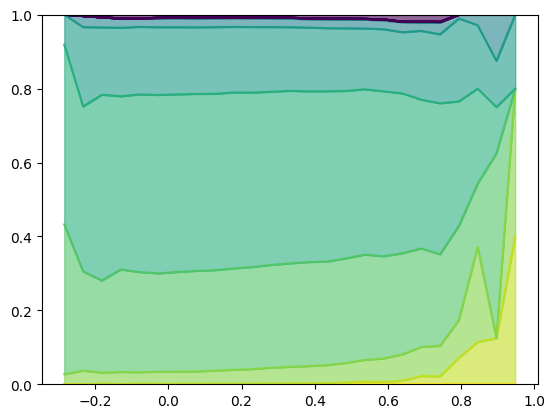

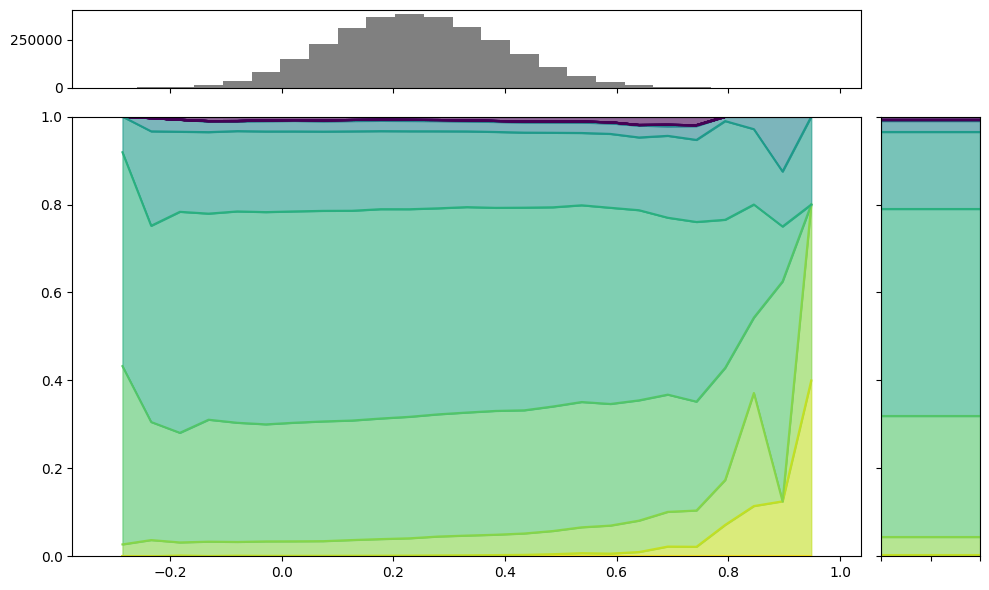

In [ ]:
x = cosine_similarities_international  # x座標のデータ
y = distances_international  # y座標のデータ

x_bins = 25
y_bins = np.array(range(22)) - 0.5

# 2次元ヒストグラムを作成
heatmap, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])

#heatmapを、x(cosine similarity)それぞれにおける割合にする
sum_for_each_x = np.sum(heatmap, axis=1, keepdims=True)
heatmap_normalized_for_each_x = heatmap / sum_for_each_x
#積み上げの折れ線グラフ
fig, ax = plt.subplots()

color_map = plt.get_cmap('viridis_r')
n_colors = heatmap_normalized_for_each_x.shape[1]

# 最初の<percentage>%は線形に色を変化させる
percentage = 0.6
linear_colors = color_map(np.linspace(0, 1, int(n_colors * percentage)))
max_color = color_map(1.0)
fixed_colors = np.array([max_color] * (n_colors - int(n_colors * percentage)))
colors = np.vstack((linear_colors, fixed_colors))

tmp_list = np.zeros(heatmap_normalized_for_each_x.shape[0])
for i in range(heatmap_normalized_for_each_x.shape[1]):
  ax.plot(xedges[:-1], tmp_list + heatmap_normalized_for_each_x[:, i], label=f'Y{i+1}', color=colors[i])
  ax.fill_between(xedges[:-1], tmp_list, tmp_list + heatmap_normalized_for_each_x[:, i], alpha=0.6, label=f'Y{i+1}', color=colors[i])
  tmp_list += heatmap_normalized_for_each_x[:, i]
ax.set_ylim(0, 1)
#ax.legend()
fig.show()
fig.savefig("similarity_and_path_length_international.pdf")
fig.savefig("similarity_and_path_length_international.svg")




#yの割合
sum_for_each_y = np.sum(heatmap, axis=0)
sum_for_each_y = sum_for_each_y / np.sum(sum_for_each_y)

## まとめて描画する
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6), layout="tight")
gs = gridspec.GridSpec(2, 2, height_ratios=[0.15, 0.85], width_ratios=[0.8, 0.1])  # 20%と80%に設定

# 各サブプロットをGridSpecで指定
ax1 = fig.add_subplot(gs[0, 0])  # 20%の高さ
ax2 = fig.add_subplot(gs[1, 0], sharex = ax1)  # 80%の高さ
ax3 = fig.add_subplot(gs[1, 1], sharey = ax2)  # 80%の高さ

axes = [ax1, ax2, ax3]

#######メインのグラフ
ax = axes[1]
color_map = plt.get_cmap('viridis_r')
n_colors = heatmap_normalized_for_each_x.shape[1]


percentage = 0.6
linear_colors = color_map(np.linspace(0, 1, int(n_colors * percentage)))
max_color = color_map(1.0)
fixed_colors = np.array([max_color] * (n_colors - int(n_colors * percentage)))
colors = np.vstack((linear_colors, fixed_colors))

tmp_list = np.zeros(heatmap_normalized_for_each_x.shape[0])
for i in range(heatmap_normalized_for_each_x.shape[1]):
  ax.plot(xedges[:-1], tmp_list + heatmap_normalized_for_each_x[:, i], label=f'Y{i+1}', color=colors[i])
  ax.fill_between(xedges[:-1], tmp_list, tmp_list + heatmap_normalized_for_each_x[:, i], alpha=0.6, label=f'Y{i+1}', color=colors[i])
  tmp_list += heatmap_normalized_for_each_x[:, i]
ax.set_ylim(0, 1)

##### Xについてのヒストグラム
ax = axes[0]
ax.bar(xedges[:-1], sum_for_each_x.flatten(), width=xedges[1]-xedges[0], color="gray")
ax.tick_params(labelbottom=False)

##### Yの割合グラフ
ax = axes[2]
tmp = 0
i = 0
for val in sum_for_each_y:
  ax.fill_between([0, 1], [tmp, tmp], [tmp + val, tmp+val], alpha=0.6, color = colors[i])
  ax.plot([0, 1], [tmp + val, tmp + val], color = colors[i])
  tmp += val
  i += 1
ax.tick_params(labelbottom=False, labelleft=False)
ax.set_xlim(0, 1)

fig.show()
fig.savefig("similarity_and_path_length_international_2.pdf")
fig.savefig("similarity_and_path_length_intertnational_2.svg")


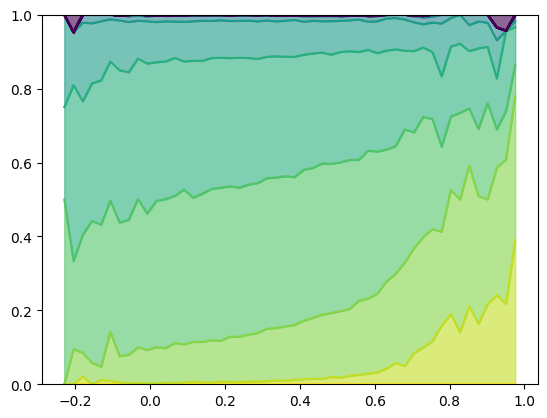

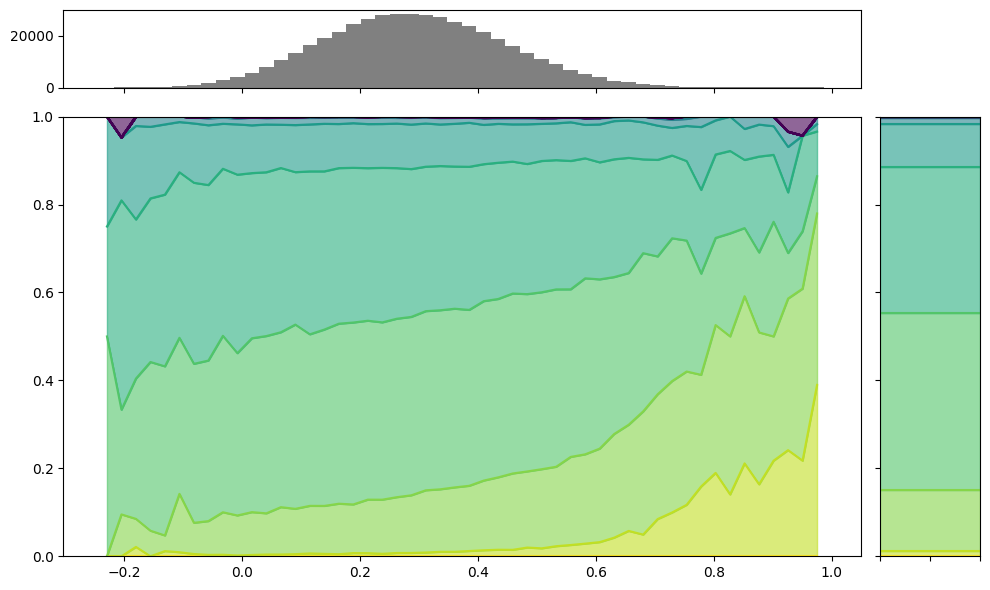

In [ ]:
x = cosine_similarities_domestic  # x座標のデータ
y = distances_domestic  # y座標のデータ

x_bins = 50
y_bins = np.array(range(22)) - 0.5

# 2次元ヒストグラムを作成
heatmap, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])

#heatmapを、x(cosine similarity)それぞれにおける割合にする
sum_for_each_x = np.sum(heatmap, axis=1, keepdims=True)
heatmap_normalized_for_each_x = heatmap / sum_for_each_x
#積み上げの折れ線グラフ
fig, ax = plt.subplots()

color_map = plt.get_cmap('viridis_r')
n_colors = heatmap_normalized_for_each_x.shape[1]

# 最初の<percentage>%は線形に色を変化させる
percentage = 0.6
linear_colors = color_map(np.linspace(0, 1, int(n_colors * percentage)))
max_color = color_map(1.0)
fixed_colors = np.array([max_color] * (n_colors - int(n_colors * percentage)))
colors = np.vstack((linear_colors, fixed_colors))

tmp_list = np.zeros(heatmap_normalized_for_each_x.shape[0])
for i in range(heatmap_normalized_for_each_x.shape[1]):
  ax.plot(xedges[:-1], tmp_list + heatmap_normalized_for_each_x[:, i], label=f'Y{i+1}', color=colors[i])
  ax.fill_between(xedges[:-1], tmp_list, tmp_list + heatmap_normalized_for_each_x[:, i], alpha=0.6, label=f'Y{i+1}', color=colors[i])
  tmp_list += heatmap_normalized_for_each_x[:, i]
ax.set_ylim(0, 1)
#ax.legend()
fig.show()
fig.savefig("similarity_and_path_length_domestic.pdf")
fig.savefig("similarity_and_path_length_domestic.svg")


#yの割合
sum_for_each_y = np.sum(heatmap, axis=0)
sum_for_each_y = sum_for_each_y / np.sum(sum_for_each_y)

## まとめて描画する
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6), layout="tight")
gs = gridspec.GridSpec(2, 2, height_ratios=[0.15, 0.85], width_ratios=[0.8, 0.1])  # 20%と80%に設定

# 各サブプロットをGridSpecで指定
ax1 = fig.add_subplot(gs[0, 0])  # 20%の高さ
ax2 = fig.add_subplot(gs[1, 0], sharex = ax1)  # 80%の高さ
ax3 = fig.add_subplot(gs[1, 1], sharey = ax2)  # 80%の高さ

axes = [ax1, ax2, ax3]

#######メインのグラフ
ax = axes[1]
color_map = plt.get_cmap('viridis_r')
n_colors = heatmap_normalized_for_each_x.shape[1]


percentage = 0.6
linear_colors = color_map(np.linspace(0, 1, int(n_colors * percentage)))
max_color = color_map(1.0)
fixed_colors = np.array([max_color] * (n_colors - int(n_colors * percentage)))
colors = np.vstack((linear_colors, fixed_colors))

tmp_list = np.zeros(heatmap_normalized_for_each_x.shape[0])
for i in range(heatmap_normalized_for_each_x.shape[1]):
  ax.plot(xedges[:-1], tmp_list + heatmap_normalized_for_each_x[:, i], label=f'Y{i+1}', color=colors[i])
  ax.fill_between(xedges[:-1], tmp_list, tmp_list + heatmap_normalized_for_each_x[:, i], alpha=0.6, label=f'Y{i+1}', color=colors[i])
  tmp_list += heatmap_normalized_for_each_x[:, i]
ax.set_ylim(0, 1)

##### Xについてのヒストグラム
ax = axes[0]
ax.bar(xedges[:-1], sum_for_each_x.flatten(), width=xedges[1]-xedges[0], color="gray")
ax.tick_params(labelbottom=False)

##### Yの割合グラフ
ax = axes[2]
tmp = 0
i = 0
for val in sum_for_each_y:
  ax.fill_between([0, 1], [tmp, tmp], [tmp + val, tmp+val], alpha=0.6, color = colors[i])
  ax.plot([0, 1], [tmp + val, tmp + val], color = colors[i])
  tmp += val
  i += 1
ax.tick_params(labelbottom=False, labelleft=False)
ax.set_xlim(0, 1)

fig.show()
fig.savefig("similarity_and_path_length_domestic_2.pdf")
fig.savefig("similarity_and_path_length_domestic_2.svg")

## Cosine similarity and odds ratio of connection counts among field categories

In [ ]:
field_names = df_fields.field_name.tolist()
df_field_pair_average_cosine_similarity = pd.DataFrame(columns=["field1", "field2", "average_cosine_similarity"])
df_attendees_with_field_name = df_attendees.copy()
df_attendees_with_field_name["field_name"] = df_attendees_with_field_name.field.map(field_name_dict)

person_vectors = df_attendee_vector[[f"vector_{i}" for i in range(50)]].to_numpy()
cosine_sim_matrix = pd.DataFrame(cosine_similarity(person_vectors), index=df_attendee_vector.index, columns=df_attendee_vector.index)

for field1 in tqdm(field_names):
  for field2 in field_names:
    attendees1 = df_attendees[df_attendees_with_field_name.field_name == field1].attendee_id.tolist()
    attendees1 = [attendee_id for attendee_id in attendees1 if attendee_id in df_attendee_vector.index.tolist()]

    attendees2 = df_attendees[df_attendees_with_field_name.field_name == field2].attendee_id.tolist()
    attendees2 = [attendee_id for attendee_id in attendees2 if attendee_id in df_attendee_vector.index.tolist()]

    total = 0
    count = 0
    for person1 in attendees1:
      for person2 in attendees2:
        if person1 != person2:
          count = count + 1
          total = total + cosine_sim_matrix.loc[person1, person2]
    if count == 0:
      value = None
    else:
      value = total / count
    if value is not None:
      df_field_pair_average_cosine_similarity.loc[len(df_field_pair_average_cosine_similarity)] = [field1, field2, value]
df_field_pair_average_cosine_similarity

100%|██████████| 21/21 [01:47<00:00,  5.14s/it]


,field1,field2,average_cosine_similarity
0,"Systematics, Phylogeny and Morphology","Systematics, Phylogeny and Morphology",0.455895
1,"Systematics, Phylogeny and Morphology",Social Insects,0.269078
2,"Systematics, Phylogeny and Morphology",Pest Management,0.222553
3,"Systematics, Phylogeny and Morphology",Ecology and Evolution,0.325185
4,"Systematics, Phylogeny and Morphology",Others,0.283860
...,...,...,...
395,"Physiology, Neurobiology and Molecular Biology",Development and Reproduction,0.370277
396,"Physiology, Neurobiology and Molecular Biology","Conservation, Biodiversity and Biogeography",0.199541
397,"Physiology, Neurobiology and Molecular Biology",Biological Control,0.220637
398,"Physiology, Neurobiology and Molecular Biology",Immunology and Pathology,0.358332


### Heatmap of cosine similarities among field categories

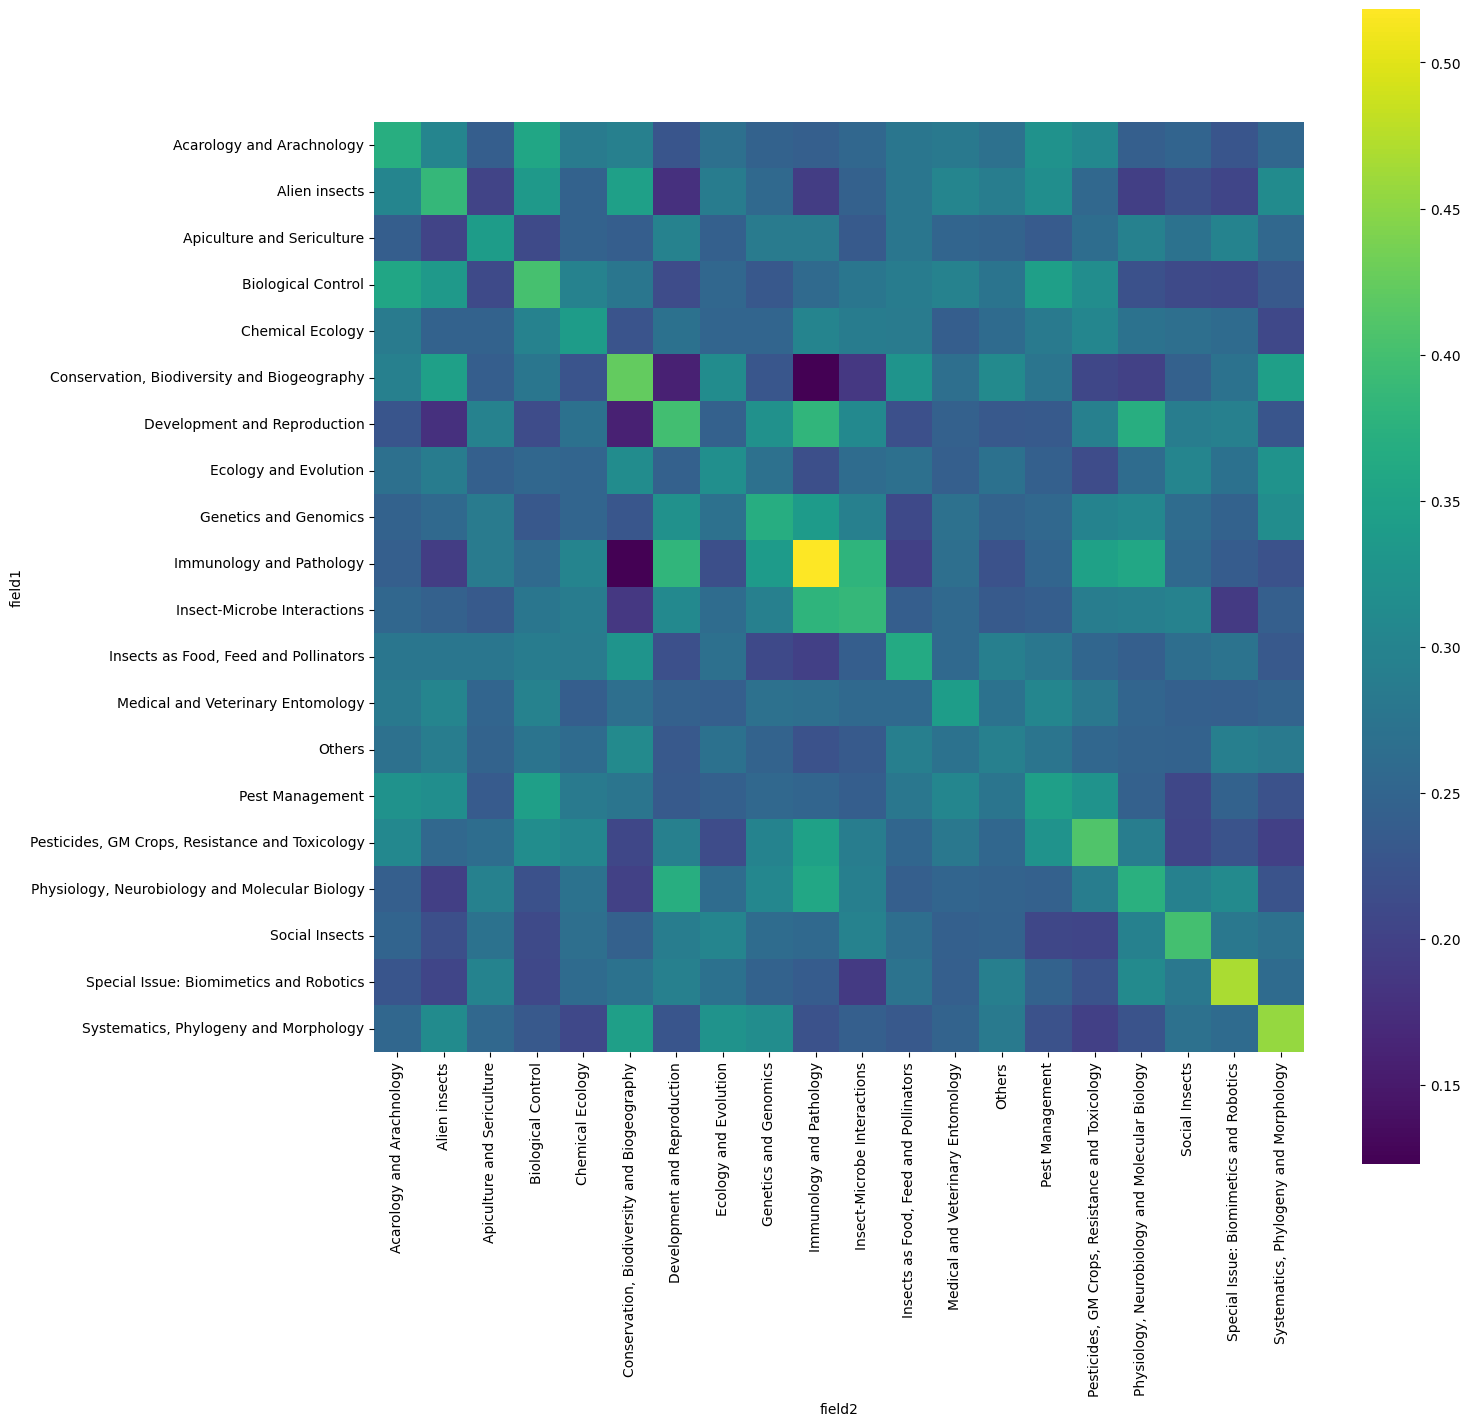

In [ ]:
matrix_average_cosine_similarity = pd.pivot_table(df_field_pair_average_cosine_similarity, index="field1", columns="field2", values="average_cosine_similarity")
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(matrix_average_cosine_similarity, cmap="viridis", ax=ax)
ax.set_aspect("equal")
fig.show()
fig.savefig("field_pair_average_cosine_similarity.pdf")
fig.savefig("field_pair_average_cosine_similarity.svg")


### Correlation between similarity and odds ratio across field pairs (Figure 3C)

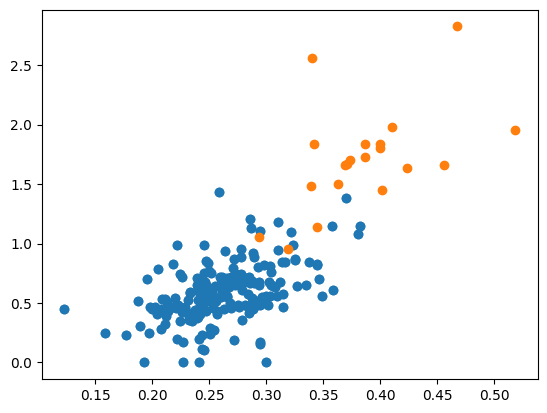

In [ ]:
df_field_similarity_and_odds = pd.merge(field_connection_odds_ratio_matrix.stack().rename("odds_ratio").reset_index().rename({"from_field_name": "field1", "to_field_name": "field2"}, axis=1),
                                        df_field_pair_average_cosine_similarity,
                                        how="left",
                                        on=["field1", "field2"])
df_field_similarity_and_odds["self_loop"] = df_field_similarity_and_odds.field1 == df_field_similarity_and_odds.field2
fig, ax = plt.subplots()

ax.scatter(df_field_similarity_and_odds[~df_field_similarity_and_odds.self_loop].average_cosine_similarity, np.log1p(df_field_similarity_and_odds[~df_field_similarity_and_odds.self_loop].odds_ratio))
ax.scatter(df_field_similarity_and_odds[df_field_similarity_and_odds.self_loop].average_cosine_similarity, np.log1p(df_field_similarity_and_odds[df_field_similarity_and_odds.self_loop].odds_ratio))

fig.show()
fig.savefig("field_similarity_and_odds.pdf")
fig.savefig("field_similarity_and_odds.svg")

## Make a field-level network based on connection odds ratio and export to GEXF (Figure 3B; visualised using Gephi)

In [ ]:
G_field = nx.Graph()
for field1, field2 in itertools.product(field_names, field_names):
  G_field.add_edge(field1, field2, weight=field_connection_odds_ratio_matrix.loc[field1, field2])
for key, row in df_fields.iterrows():
  G_field.nodes[row.field_name]["dominance_of_connections"] = row.dominance_of_connections
  G_field.nodes[row.field_name]["number_of_attendees"] = row.number_of_attendees
  G_field.nodes[row.field_name]["number_of_connections"] = row.number_of_connections
  G_field.nodes[row.field_name]["number_of_inner_connections"] = row.number_of_inner_connections
  G_field.nodes[row.field_name]["number_of_outer_connections"] = row.number_of_outer_connections
  G_field.nodes[row.field_name]["ratio_of_inner_connections"] = row.ratio_of_inner_connections
  G_field.nodes[row.field_name]["odds_ratio_of_inner_connections"] = row.odds_ratio_of_inner_connections

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
<ipython-input-37-c22d1b7fe039>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (pos.x[i], pos.y[i]))


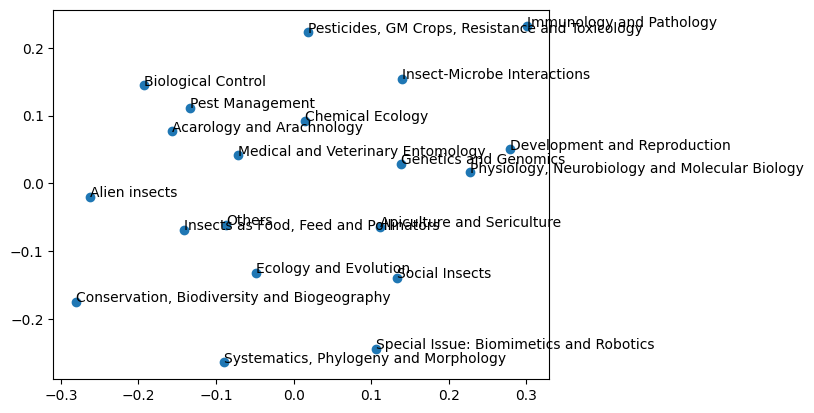

In [ ]:
# Calculate MDS from similarity
#distance_matrix = (1 - matrix_average_cosine_similarity.values) ** (1/2)
distance_matrix = 1 - matrix_average_cosine_similarity.values
mds = MDS(n_components=2, random_state=0) #MDS
#mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0) #NMDS
pos = mds.fit_transform(distance_matrix)
pos = pd.DataFrame(pos, index=matrix_average_cosine_similarity.index, columns=["x", "y"])
fig, ax = plt.subplots()
ax.scatter(pos.x, pos.y)
for i, txt in enumerate(pos.index):
    ax.annotate(txt, (pos.x[i], pos.y[i]))
fig.show()

In [ ]:
# apply position to gexf
for node in G_field.nodes():
    if node in pos.index:
        x = pos.at[node, 'x']
        y = pos.at[node, 'y']
        # zは必要に応じて0など任意の値を設定
        G_field.nodes[node]['viz'] = {
            'position': {
                'x': float(x),
                'y': float(y),
                'z': 0.0
            }
        }
nx.write_gexf(G_field, "field_odds_ratio.gexf")

## Heatmap of odds ratio of connection couts among field categories (Figure 3A)

In [ ]:
# Calculate MDS from similarity
#distance_matrix = (1 - matrix_average_cosine_similarity.values) ** (1/2)
distance_matrix = 1 - matrix_average_cosine_similarity.values
mds = MDS(n_components=1, random_state=0) #MDS
#mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0) #NMDS
pos = mds.fit_transform(distance_matrix)
pos = pd.DataFrame(pos, index=matrix_average_cosine_similarity.index, columns=["x"])
pos = pos.sort_values("x")
field_order = pos.index.tolist()
field_connection_odds_ratio_matrix = field_connection_odds_ratio_matrix.reindex(field_order, axis=0).reindex(field_order, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


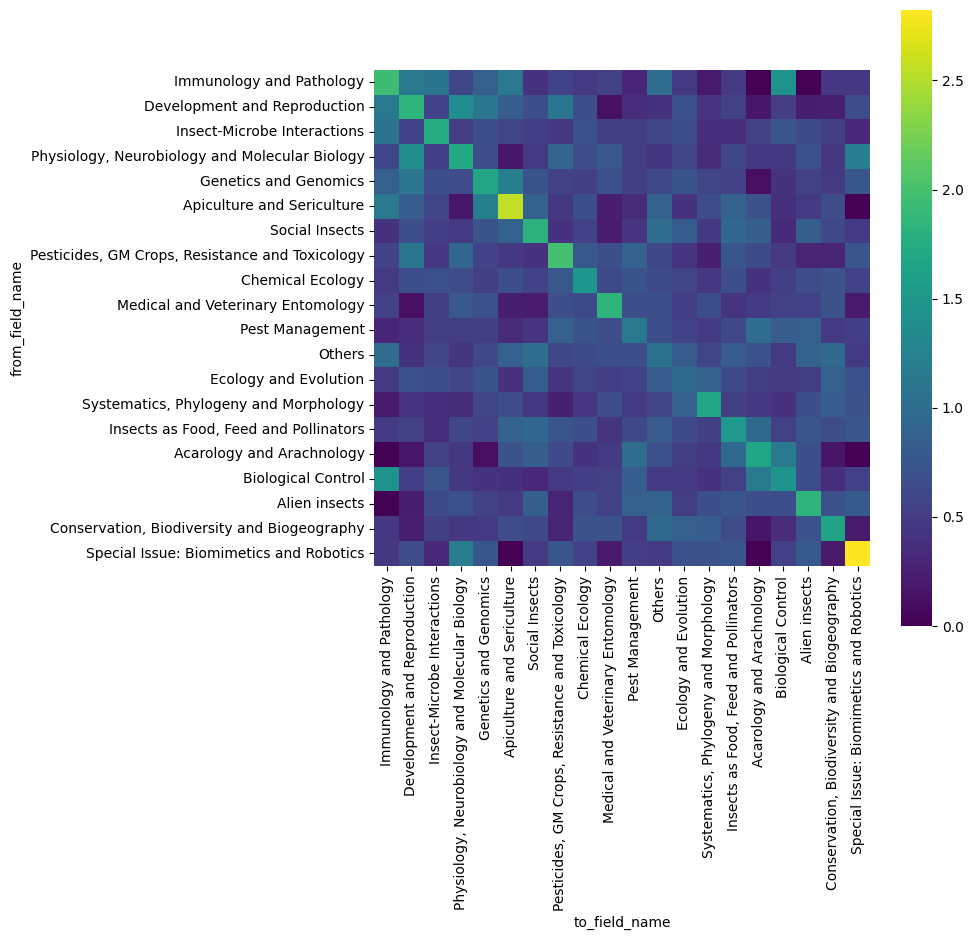

In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(np.log1p(field_connection_odds_ratio_matrix), cmap="viridis", ax=ax)
ax.set_aspect("equal")
fig.show()
fig.savefig("heatmap_field_connection_odds_ratio.pdf")
fig.savefig("heatmap_field_connection_odds_ratio.svg")

# Analysis based on countries

## Aggregate each countries' interaction

In [ ]:
country_names = set(df_connections.to_country.unique().tolist() + df_connections.from_country.unique().tolist())

df_countries = pd.DataFrame(columns=["country", "number_of_attendees", "number_of_inner_connections", "number_of_outer_connections", "number_of_connections"])
for country_name in country_names:
  number_of_attendees = len(set(df_connections[df_connections.from_country == country_name].from_person.tolist() + df_connections[df_connections.to_country == country_name].to_person.tolist() ))
  number_of_inner_connections = len(df_connections[(df_connections.from_country == country_name) & (df_connections.to_country == country_name)])
  number_of_outer_connections = len(df_connections[(df_connections.from_country == country_name) & (df_connections.to_country != country_name)])
  number_of_connections = len(df_connections[df_connections.from_country == country_name])
  dat = [country_name, number_of_attendees, number_of_inner_connections, number_of_outer_connections, number_of_connections]
  df_countries.loc[len(df_countries)] = dat
df_countries["dominance_of_connections"] = df_countries.number_of_connections / df_countries.number_of_connections.sum()
df_countries["ratio_of_inner_connections"] = df_countries.number_of_inner_connections / df_countries.number_of_connections
df_countries["odds_ratio_of_inner_connections"] = (df_countries.ratio_of_inner_connections / (1 - df_countries.ratio_of_inner_connections)) / (df_countries.dominance_of_connections / (1 - df_countries.dominance_of_connections))

## Aggregate interactions between each pair of countries

In [ ]:
df_country_connection_matrix = df_connections.pivot_table(index="from_country", columns="to_country", values="connection_id", aggfunc="count").fillna(0)
df_country_connection_matrix = df_country_connection_matrix.reindex(country_names, axis=0).reindex(country_names, axis=1)
df_country_connection_proportion_matrix = df_country_connection_matrix / df_country_connection_matrix.sum().sum()

df_country_connection_expected_matrix = pd.DataFrame(np.outer(np.array(df_countries.dominance_of_connections), np.array(df_countries.dominance_of_connections)),
                                               columns=list(country_names),
                                               index=list(country_names)
                                               )

df_country_connection_odds_ratio_matrix = (df_country_connection_proportion_matrix / (1 - df_country_connection_proportion_matrix)) / (df_country_connection_expected_matrix / (1 - df_country_connection_expected_matrix))

#fig, ax = plt.subplots(figsize=(20, 20))
#sns.heatmap(np.log1p(df_country_connection_odds_ratio_matrix), cmap="viridis", ax=ax)
#fig.show()

## Metrics for each country

### Odds ratio of intra-country interactions whith bayesian credible intervals

In [ ]:
def odds_ratio_credible(x, N, q, cred_mass, prior_beta_dist=[1, 1]):
  #ベータ分布に基づく乱数
  random_numbers = beta.rvs(x + prior_beta_dist[0], N - x + prior_beta_dist[1], size=100000)
  random_odds_ratio = (random_numbers / (1 - random_numbers)) / (q / (1 - q))
  percentile = np.percentile(random_odds_ratio, [cred_mass, 100 - cred_mass])
  unbiased = np.percentile(random_odds_ratio, 50)

  hpdi = compute_hpdi(random_odds_ratio, cred_mass=cred_mass)
  observed = ((x/N) / (1 - x/N)) / (q / (1 - q))
  return percentile, hpdi, observed, unbiased

def compute_hpdi(samples, cred_mass=0.95):
    # サンプルを昇順にソート
    sorted_samples = np.sort(samples)
    N = len(sorted_samples)

    # 信頼区間内のサンプル数を計算
    interval_idx_inc = int(np.floor(cred_mass * N))

    if interval_idx_inc < 1:
        raise ValueError("サンプル数が不足しているため、HPDIを計算できません。")

    # 全ての可能な区間の幅を計算
    n_intervals = N - interval_idx_inc
    interval_width = sorted_samples[interval_idx_inc:] - sorted_samples[:n_intervals]

    # 最小幅の区間を特定
    min_idx = np.argmin(interval_width)
    hdi_min = sorted_samples[min_idx]
    hdi_max = sorted_samples[min_idx + interval_idx_inc]

    return [hdi_min, hdi_max]

In [ ]:
# bayesianでオッズ比の区間推定
df_countries
for key, row in df_countries.iterrows():
  percentile, hpdi, observed, unbiased = odds_ratio_credible(
    row.number_of_inner_connections,
    row.number_of_connections,
    row.dominance_of_connections,
    cred_mass=0.90,
    prior_beta_dist=[1, 1])
  df_countries.loc[key, "odds_ratio_CI_lower"] = percentile[0]
  df_countries.loc[key, "odds_ratio_CI_upper"] = percentile[1]
  df_countries.loc[key, "odds_ratio_HPDI_lower"] = hpdi[0]
  df_countries.loc[key, "odds_ratio_HPDI_upper"] = hpdi[1]
  df_countries.loc[key, "odds_ratio_unbiased"] = unbiased

<ipython-input-45-6a487421b82e>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_tmp.country, rotation=90)


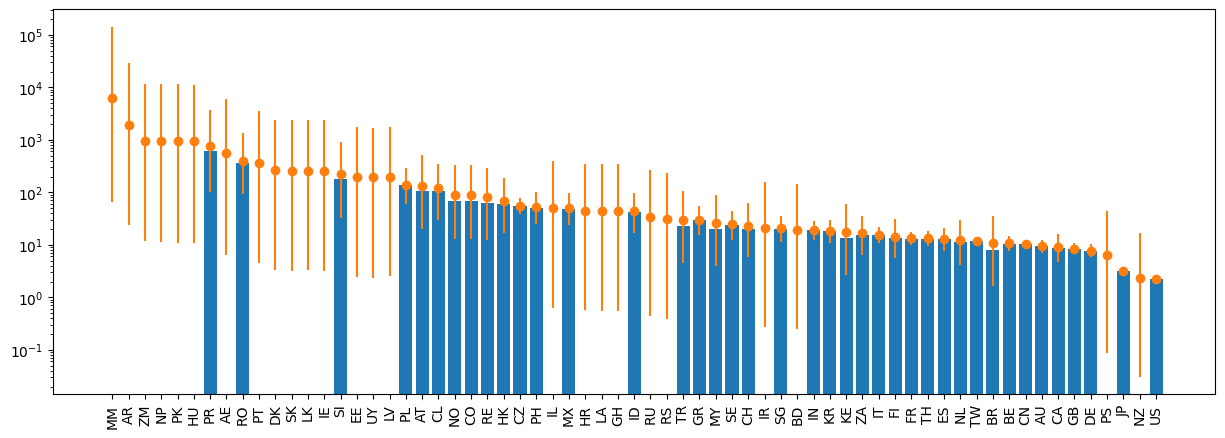

In [ ]:
df_tmp = df_countries.sort_values("odds_ratio_unbiased", ascending=False)
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(x = df_tmp.country, height = df_tmp.odds_ratio_of_inner_connections)
ax.errorbar(x = df_tmp.country, y = df_tmp.odds_ratio_unbiased,
            yerr = [df_tmp.odds_ratio_unbiased - df_tmp.odds_ratio_CI_lower, df_tmp.odds_ratio_CI_upper - df_tmp.odds_ratio_unbiased],
            linestyle='None',
            fmt="o",
            color = "tab:orange")

ax.set_xticklabels(df_tmp.country, rotation=90)
ax.set_yscale("log")

fig.show()

### Disparities in tnteracted countries (JSD) (Figure 4D)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result 

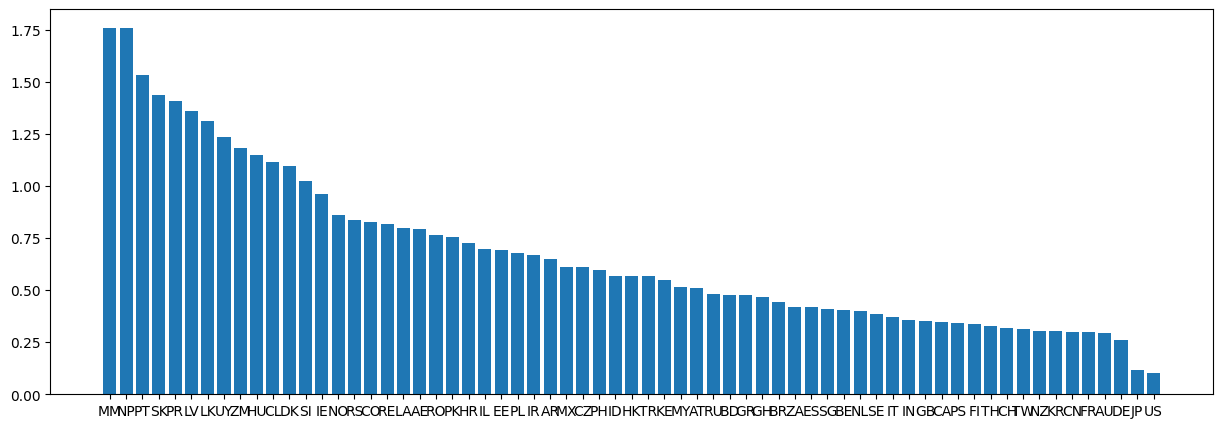

In [ ]:
# Jensen-shannon divergence
df_country_connection_matrix
for key, row in df_countries.iterrows():
  df_tmp = df_country_connection_matrix.loc[row.country]
  P = df_tmp / df_tmp.sum()
  E = df_countries["dominance_of_connections"]
  M = (np.array(P) + np.array(E)) / 2
  divergence = np.sum(np.where(P > 0, P * np.log2(P / M), 0)) + np.sum(E * np.log2(E / M)) #Here, the warinig of zero divison can be ignored.
  df_countries.loc[key, "divergence"] = divergence
df_tmp = df_countries.sort_values("divergence", ascending=False)
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(x = df_tmp.country, height = df_tmp.divergence)
fig.show()

fig.savefig("country_interaction_divergence.pdf")
fig.savefig("country_interaction_divergence.svg")


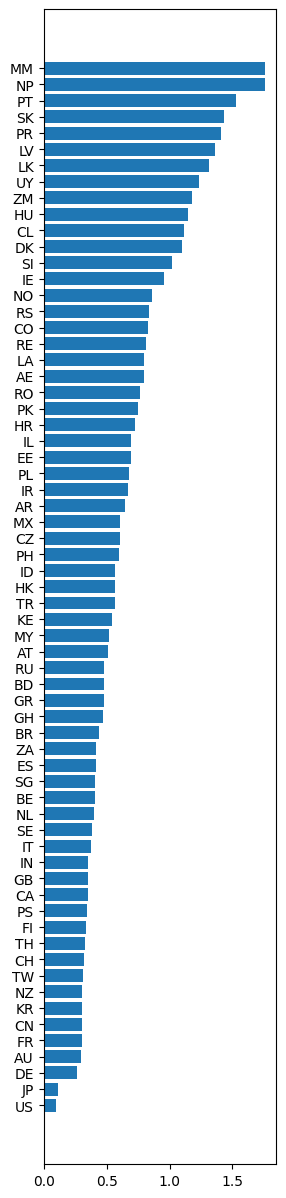

In [ ]:
fig, ax = plt.subplots(figsize=(3, 15))
df_tmp = df_tmp.sort_values("divergence", ascending=True)
ax.barh(y = df_tmp.country, width = df_tmp.divergence)
fig.show()

fig.savefig("country_interaction_divergence_vertical.pdf")
fig.savefig("country_interaction_divergence_vertical.svg")

## Connections among countries

### Heatmap of odds ratio connection count among countries (Figure 4A)

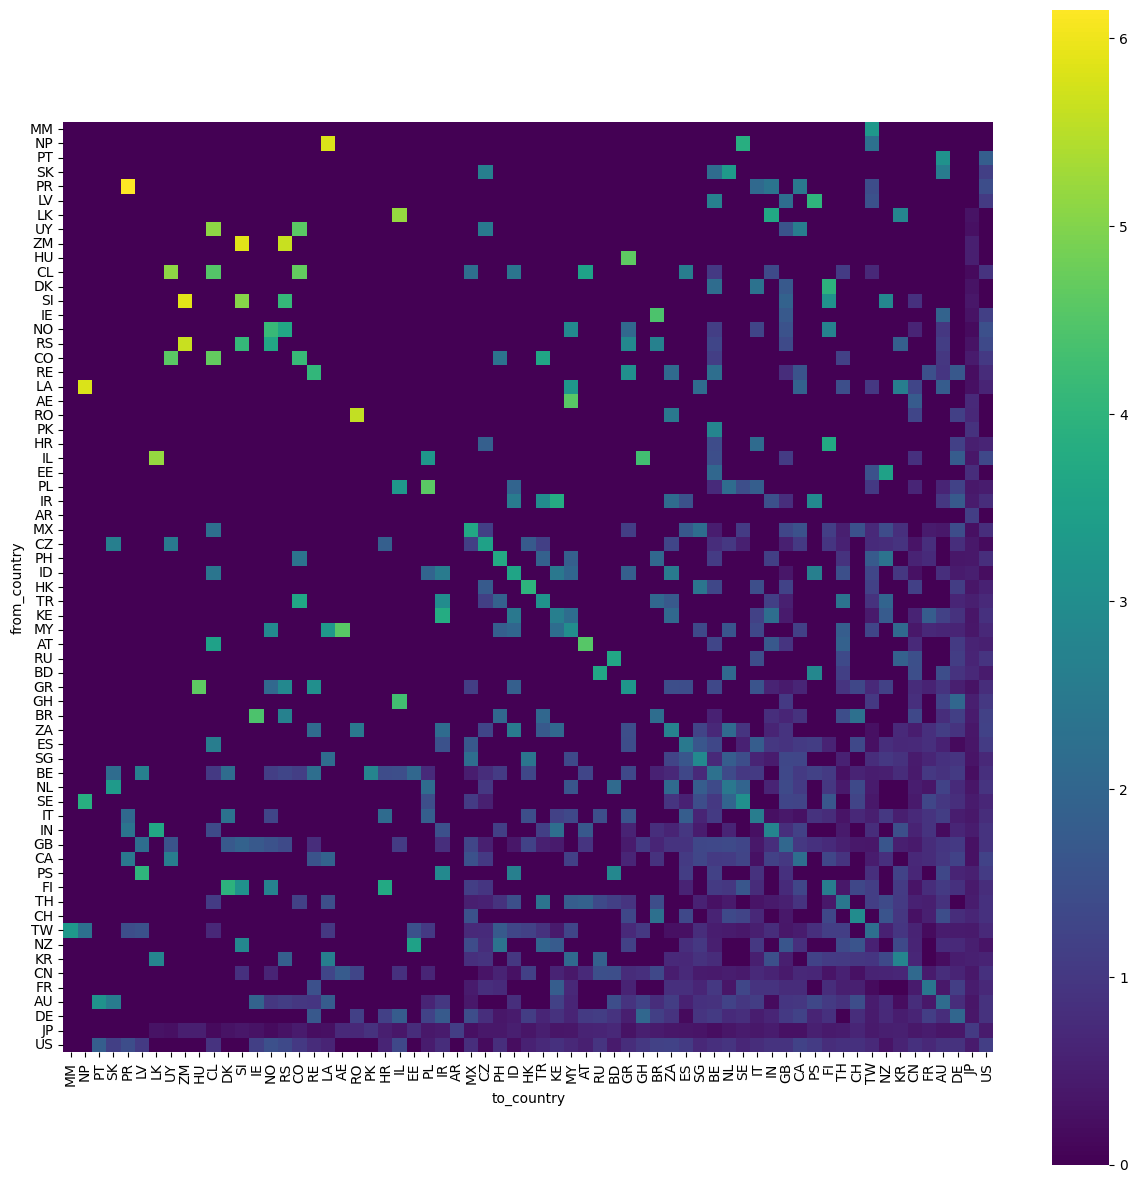

In [ ]:
# ヒートマップ
country_order = df_countries.sort_values("divergence", ascending=False).country.tolist()
df_country_connection_odds_ratio_matrix = df_country_connection_odds_ratio_matrix.reindex(country_order, axis=0).reindex(country_order, axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(np.log1p(df_country_connection_odds_ratio_matrix), cmap="viridis", ax=ax)
ax.set_aspect('equal')
fig.show()
fig.savefig("country_odds_ratio_heatmap.pdf")
fig.savefig("country_odds_ratio_heatmap.svg")


In [ ]:
# gexf

### Effect of languages (Figure 5B)

In [ ]:
df_country_pairs = pd.DataFrame(columns=["from_country", "to_country", "number_of_connections", "odds_ratio"])
for country1, country2 in itertools.combinations(country_names, 2):
  number_of_connections = df_country_connection_matrix.loc[country1, country2]
  odds_ratio = df_country_connection_odds_ratio_matrix.loc[country1, country2]
  dat = [country1, country2, number_of_connections, odds_ratio]
  df_country_pairs.loc[len(df_country_pairs)] = dat
for country in country_names:
  number_of_connections = df_country_connection_matrix.loc[country, country]
  odds_ratio = df_country_connection_odds_ratio_matrix.loc[country, country]
  dat = [country, country, number_of_connections, odds_ratio]
  df_country_pairs.loc[len(df_country_pairs)] = dat
df_country_pairs["self_loop"] = df_country_pairs.from_country == df_country_pairs.to_country
df_country_pairs["from_country_languages"] = df_country_pairs.from_country.map(country_language_dict)
df_country_pairs["to_country_languages"] = df_country_pairs.to_country.map(country_language_dict)
df_country_pairs["have_common_languages"] = df_country_pairs.apply(lambda x: len(set(x.from_country_languages) & set(x.to_country_languages)) > 0, axis=1)
df_country_pairs.loc[df_country_pairs.self_loop, "type"] = "same_country"
df_country_pairs.loc[(~df_country_pairs.self_loop) & (df_country_pairs.have_common_languages), "type"] = "common_language"
df_country_pairs.loc[(~df_country_pairs.self_loop) & (~df_country_pairs.have_common_languages), "type"] = "different_language"

<ipython-input-51-81bfbb899f46>:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(x=df_country_pairs.have_common_languages, y=np.log1p(df_country_pairs.odds_ratio), ax=ax, scale="area", color="lightgray", cut=0)


7.1437607309372275 9.081142058909644e-13


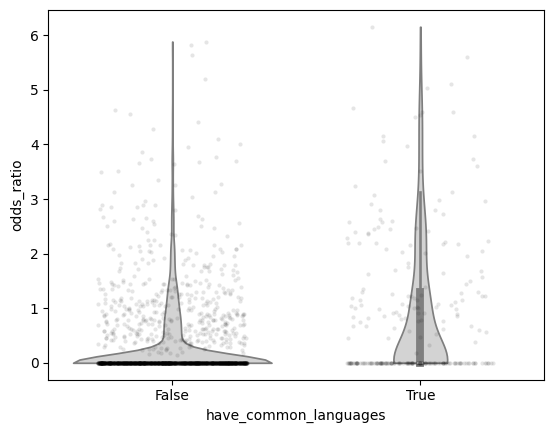

In [ ]:
fig, ax = plt.subplots()
sns.violinplot(x=df_country_pairs.have_common_languages, y=np.log1p(df_country_pairs.odds_ratio), ax=ax, scale="area", color="lightgray", cut=0)
sns.stripplot(x=df_country_pairs.have_common_languages, y=np.log1p(df_country_pairs.odds_ratio), ax=ax, alpha=0.1, size=3, color="black", jitter=0.3)
fig.show()
fig.savefig("country_language_violin.pdf")
fig.savefig("country_language_violin.svg")


statistic, pvalue = stats.ranksums(df_country_pairs[df_country_pairs.have_common_languages == True].odds_ratio, df_country_pairs[df_country_pairs.have_common_languages == False].odds_ratio)
print(statistic, pvalue)

<ipython-input-52-5d368f753c9e>:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(x=df_country_pairs["type"], y=np.log1p(df_country_pairs.odds_ratio), ax=ax, scale="area", color="lightgray", cut=0)


4.550545738591815 5.350695397514353e-06


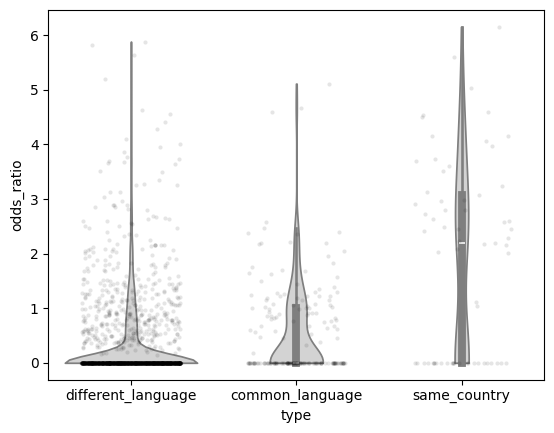

In [ ]:
fig, ax = plt.subplots()
sns.violinplot(x=df_country_pairs["type"], y=np.log1p(df_country_pairs.odds_ratio), ax=ax, scale="area", color="lightgray", cut=0)
sns.stripplot(x=df_country_pairs["type"], y=np.log1p(df_country_pairs.odds_ratio), ax=ax, alpha=0.1, size=3, color="black", jitter=0.3)
fig.show()
fig.savefig("country_language_and_self_loop_violin.pdf")
fig.savefig("country_language_and_self_loop_violin.svg")


statistic, pvalue = stats.ranksums(df_country_pairs[df_country_pairs["type"] == "common_language"].odds_ratio, df_country_pairs[df_country_pairs["type"] == "different_language"].odds_ratio)
print(statistic, pvalue)

In [ ]:
import scipy.stats as st
def wilcoxon_bonferroni(df, groupby, compared_value):
  #groupのリストを作成
  groups = df.groupby(groupby)
  group_list = []
  for key, df_group in groups:
    group_list.append(key)
  #比較する組み合わせのリストを作成
  comparison_list = []
  for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
      comparison_list.append([group_list[i], group_list[j]])
  p_matrix = pd.DataFrame()
  for comparison in comparison_list:
    #print("============================")
    #print(str(comparison[0]) + "と" + str(comparison[1]) + "の比較")
    group0 = df[df[groupby] == comparison[0]]
    group1 = df[df[groupby] == comparison[1]]
    p = st.mannwhitneyu(group0[compared_value], group1[compared_value], alternative="two-sided").pvalue
    #print("p = " + "{:.1e}".format(p) + " (多重比較未補正)")
    #print("p = " + "{:.1e}".format(min(1, p * len(comparison_list))) + " (多重比較補正済; Bonferroni)")
    p_matrix.at[comparison[0], comparison[1]] = p * len(comparison_list)
    #print("============================")
  #print(p_matrix)
  return p_matrix

In [ ]:
wilcoxon_bonferroni(df_country_pairs, "type", "odds_ratio")

,different_language,same_country
common_language,1.067426e-08,2.830389e-07
different_language,NaN,1.688655e-18


## export GEXF (Figure 5A; Visualised using Gephi)

In [ ]:
G_country = nx.Graph()
for key, row in df_country_pairs.iterrows():
  G_country.add_edge(row.from_country, row.to_country, weight=row.odds_ratio, have_common_languages=row.have_common_languages)
for key, row in df_countries.iterrows():
  G_country.nodes[row.country]["dominance_of_connections"] = row.dominance_of_connections
  G_country.nodes[row.country]["number_of_attendees"] = row.number_of_attendees
  G_country.nodes[row.country]["number_of_connections"] = row.number_of_connections
  G_country.nodes[row.country]["number_of_inner_connections"] = row.number_of_inner_connections
  G_country.nodes[row.country]["number_of_outer_connections"] = row.number_of_outer_connections
  G_country.nodes[row.country]["ratio_of_inner_connections"] = row.ratio_of_inner_connections
  G_country.nodes[row.country]["odds_ratio_of_inner_connections"] = row.odds_ratio_of_inner_connections
  G_country.nodes[row.country]["divergence"] = row.divergence
nx.write_gexf(G_country, "country_odds_ratio.gexf")

# Analysis based on position (student or non-student) (Figure 6)

In [ ]:
df_for_position = df_connections.copy()
df_for_position["from_student"] = df_for_position.from_attend_as == "Student"
df_for_position["to_student"] = df_for_position.to_attend_as == "Student"

count_s_s = len(df_for_position[(df_for_position.from_student == True) & (df_for_position.to_student == True)]) / 2
count_s_n = len(df_for_position[(df_for_position.from_student == True) & (df_for_position.to_student == False)]) / 1
count_n_n = len(df_for_position[(df_for_position.from_student == False) & (df_for_position.to_student == False)]) / 2
print(f"Student-Student: {count_s_s}", f"Student-Non-Student: {count_s_n}", f"Non-Student-Non-Student: {count_n_n}", f"total: {count_s_s + count_s_n + count_n_n}", sep="\n")

observed_counts = [count_s_s, count_s_n, count_n_n]

Student-Student: 1113.0
Student-Non-Student: 2548.0
Non-Student-Non-Student: 3851.0
total: 7512.0


In [ ]:
count_student = count_s_s + count_s_n / 2
count_non_student = count_n_n + count_s_n / 2
print(f"Student: {count_student}")
print(f"Non_student: {count_non_student}")
print(f"total: {count_student + count_non_student}")

Student: 2387.0
Non_student: 5125.0
total: 7512.0


In [ ]:
student_activity = count_student / (count_student + count_non_student) ** (1/2)
non_student_activity = count_non_student / (count_student + count_non_student) ** (1/2)

expected_student_student = student_activity ** 2
expected_non_student_non_student = non_student_activity ** 2
expected_student_non_student = student_activity * non_student_activity * 2
print("学-学の期待値", expected_student_student)
print("非-非の期待値", expected_non_student_non_student)
print("学-非の期待値", expected_student_non_student)

expected_counts = [expected_student_student, expected_student_non_student, expected_non_student_non_student]
np.sum(expected_counts)

学-学の期待値 758.4889510117146
非-非の期待値 3496.488951011714
学-非の期待値 3257.0220979765704


7511.999999999999

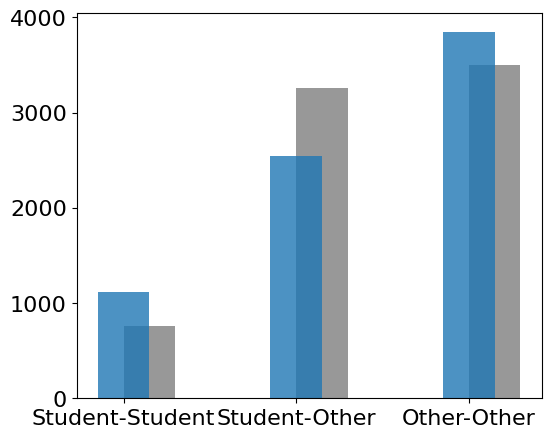

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
#plt.bar(["Student-Student", "Student-Other", "Other-Other"], observed_counts, label="observed", align="edge", width=-0.3)
#plt.bar(["Student-Student", "Student-Other", "Other-Other"], expected_counts, label="expected", color="tab:gray", align="edge", width=0.3)

plt.bar(["Student-Student", "Student-Other", "Other-Other"], expected_counts, label="expected", color="tab:gray", align="edge", width=0.3, alpha=0.8)
plt.bar(["Student-Student", "Student-Other", "Other-Other"], observed_counts, label="observed", color="tab:blue",align="center", width=0.3, alpha=0.8)
fig.patch.set_alpha(0)
#軸目盛りの文字サイズを12ptに
ax.tick_params(labelsize=16)
#ax.legend()

fig.show()
fig.savefig("position_barplot.pdf")
fig.savefig("position_barplot.svg")


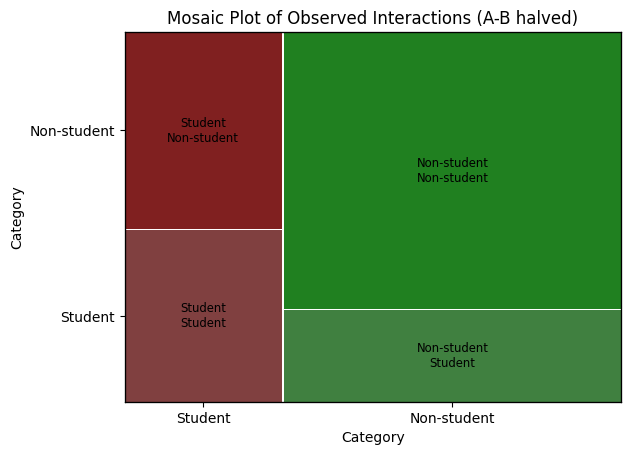

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic
obs_matrix = np.array([[observed_counts[0], observed_counts[1]/2],
                       [observed_counts[1]/2, observed_counts[2]]])
exp_matrix = np.array([[expected_counts[0], expected_counts[1]/2],
                       [expected_counts[1]/2, expected_counts[2]]])

fig1, ax1 = plt.subplots()
data_dict = {
    ('Student','Student'): obs_matrix[0,0],
    ('Student','Non-student'): obs_matrix[0,1],
    ('Non-student','Student'): obs_matrix[1,0],
    ('Non-student','Non-student'): obs_matrix[1,1]
}

mosaic(data_dict, ax=ax1, title='Mosaic Plot of Observed Interactions (A-B halved)')
ax1.set_xlabel('Category')
ax1.set_ylabel('Category')

fig1.show()

fig1.savefig("position_mosaicplot.pdf")
fig1.savefig("position_mosaicplot.svg")


# Download files

In [ ]:

import os
import zipfile
from google.colab import files
file_list = os.listdir()
file_list = [filename for filename in file_list if filename.endswith(".pdf") or filename.endswith(".gexf") or filename.endswith(".svg")]
file_list = sorted(file_list)
with zipfile.ZipFile('archive.zip', 'w') as zipf:
  for filename in file_list:
    zipf.write(filename) # ファイルをzipファイルに追加

files.download('archive.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>